In [1]:
#Nguyễn Thị Tuyết Ngân - K214051252
import pandas as pd
import matplotlib.pyplot as plt
import squarify
from matplotlib.patches import Rectangle
import numpy as np
from scipy.interpolate import splrep, splev
import seaborn as sns
from ta.trend import MACD
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
from finta import TA
import mplfinance as mpf
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import webbrowser
from scipy.signal import find_peaks
import plotly.subplots as sp

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4292\3250088687.py:17: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4292\3250088687.py:18: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<h1> XỬ LÝ DATA <h1>

In [2]:
# Tạo một danh sách chứa tên các file Excel
files = [
    '2018-Vietnam.xlsx',
    '2019-Vietnam.xlsx',
    '2020-Vietnam.xlsx',
    '2021-Vietnam.xlsx',
    '2022-Vietnam.xlsx',
]

# Tạo một danh sách để lưu trữ các DataFrame của các năm
dfs = []

# Lặp qua từng file và thực hiện xử lý
for file in files:
    # Đọc dữ liệu từ file Excel và biến nó thành DataFrame
    df = pd.read_excel(file)

    # Xóa các hàng có giá trị là "Unnamed"
    df = df.loc[~df.iloc[:, 0].astype(str).str.contains('Unnamed')]

    # Thay thế header bằng hàng dưới
    header_row_index = df[df.iloc[:, 0] == 'STT'].index[0]
    df.columns = df.iloc[header_row_index]

    # Loại bỏ các hàng không phải là header và đặt lại chỉ số
    df = df.iloc[header_row_index + 1:]

    # Xóa 11 hàng cuối cùng
    df = df.iloc[:-11].reset_index(drop=True)

    # Thêm DataFrame vào danh sách
    dfs.append(df)

# Hiển thị DataFrame cho năm 2019, 2020, 2021, 2022
df_2018 = dfs[0]
df_2019 = dfs[1]
df_2020 = dfs[2]
df_2021 = dfs[3]
df_2022 = dfs[4]

# Đường dẫn tới file Excel
excel_file_path = "Price-Vol VN 2015-2023.xlsx"

# Đọc dữ liệu từ các sheet trong file Excel
df_price = pd.read_excel(excel_file_path, sheet_name="Price")
df_volume = pd.read_excel(excel_file_path, sheet_name="Volume")
# Chỉnh cột "Code" để chỉ có 3 chữ cái ở giữa
df_price["Code"] = df_price["Code"].str.extract("(\w\w\w)")
df_volume["Code"] = df_volume["Code"].str.extract("(\w\w\w)")

price = df_price[df_price['Code'] == "PNJ"]
vol = df_volume[df_volume['Code'] == "PNJ"]
# Hàm chuyển định dạng dữ liệu
def stock_data(df):
    df = pd.concat([df.columns.to_frame().T, df], ignore_index=True)
    df.columns = range(len(df.columns))
    df = df.drop(df.columns[[0, 1, 2]], axis=1)
    df = df.T
    df.columns = ["Ngày", "Giá"]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index('Ngày')
    return df

# Chuẩn bị dữ liệu
price = stock_data(price)
vol = stock_data(vol)
vol.rename(columns={'Giá': 'Khối lượng'}, inplace=True)

price_vol = pd.concat([price, vol], axis=1)
price_vol = price_vol.fillna(0)

<h1> VẼ BIỂU ĐỒ <h1>

Lợi nhuận sau thuế thu nhập doanh nghiệp

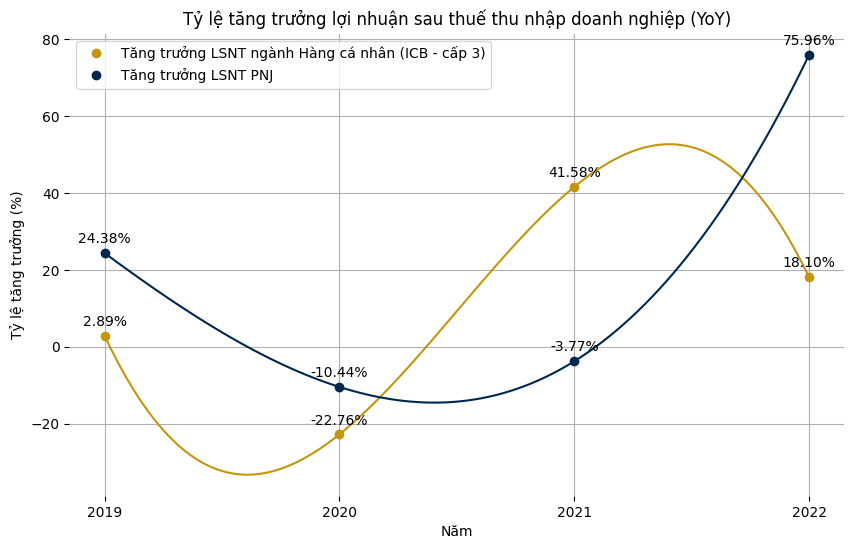

In [23]:
# Lấy giá trị cột chứa "KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp" cho từng năm
column_name = "KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp"
profits = []

for i, df in enumerate(dfs):
    year = 2018 + i
    matching_columns = df.filter(like=column_name)
    column_values = matching_columns[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean_profit = np.mean(column_values)
    profits.append(mean_profit)

# Tính toán tỷ lệ tăng trưởng YoY cho tổng quan
growth_rates = []
for i in range(1, len(profits)):
    current_profit = profits[i]
    previous_profit = profits[i - 1]
    growth_rate = (current_profit - previous_profit) / previous_profit * 100
    growth_rates.append(growth_rate)

# Lấy giá trị lợi nhuận sau thuế của công ty PNJ cho từng năm
company_name = "PNJ"
pnj_profits = []

for i, df in enumerate(dfs):
    year = 2018 + i
    matching_columns = df.filter(like=column_name)
    column_values = matching_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_profits.append(column_values.values[0])

# Tính toán tỷ lệ tăng trưởng YoY cho công ty PNJ
pnj_growth_rates = []
for i in range(1, len(pnj_profits)):
    current_profit = pnj_profits[i]
    previous_profit = pnj_profits[i - 1]
    growth_rate = (current_profit - previous_profit) / previous_profit * 100
    pnj_growth_rates.append(growth_rate)

# Tạo đường cong nội suy cho PNJ
years = range(2019, 2023)
smooth_years = np.linspace(min(years), max(years), num=100)
pnj_tck = splrep(years, pnj_growth_rates, s=None)
pnj_smooth_growth_rates = splev(smooth_years, pnj_tck)

# Tạo đường cong nội suy cho tổng quan
years = range(2019, 2023)
smooth_years = np.linspace(min(years), max(years), num=100)
grow_tck = splrep(years, growth_rates, s=None)
smooth_growth_rates = splev(smooth_years, grow_tck)

# Tạo một hình mới với kích thước tùy chỉnh
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ tỷ lệ tăng trưởng YoY với đường cong uốn lượn và lưới
plt.plot(years, growth_rates, 'o', color='#C2960D', label='Tăng trưởng LSNT ngành Hàng cá nhân (ICB - cấp 3)')
plt.plot(smooth_years, smooth_growth_rates, color='#C2960D')
plt.plot(years, pnj_growth_rates, 'o', color='#00284E', label='Tăng trưởng LSNT PNJ')
plt.plot(smooth_years, pnj_smooth_growth_rates, color='#00284E')

plt.xticks(years)  # Tắt hiển thị các giá trị x nhỏ
plt.grid(True)  # Thêm lưới
plt.box(False)

plt.xlabel("Năm")
plt.ylabel("Tỷ lệ tăng trưởng (%)")
plt.title("Tỷ lệ tăng trưởng lợi nhuận sau thuế thu nhập doanh nghiệp (YoY)")
plt.legend()

# Hiển thị phần trăm trên các chấm năm (Tổng quan)
for i in range(len(years)):
    plt.annotate(f"{growth_rates[i]:.2f}%", (years[i], growth_rates[i] + 1.8), ha='center', va='bottom')

# Hiển thị phần trăm trên các chấm năm (PNJ)
for i in range(len(years)):
    plt.annotate(f"{pnj_growth_rates[i]:.2f}%", (years[i], pnj_growth_rates[i] + 1.8), ha='center', va='bottom')

plt.show()

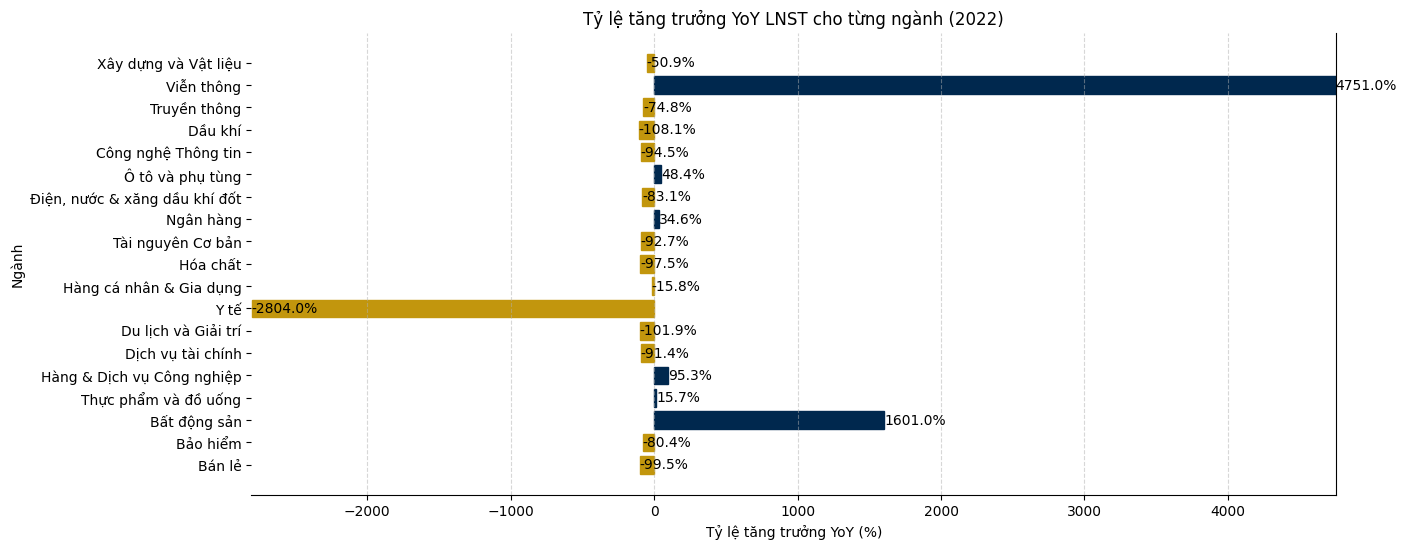

In [24]:
column_name = "KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp"
industries = [
    "Bán lẻ",
    "Bảo hiểm",
    "Bất động sản",
    "Thực phẩm và đồ uống",
    "Hàng & Dịch vụ Công nghiệp",
    "Dịch vụ tài chính",
    "Du lịch và Giải trí",
    "Y tế",
    "Hàng cá nhân & Gia dụng",
    "Hóa chất",
    "Tài nguyên Cơ bản",
    "Ngân hàng",
    "Điện, nước & xăng dầu khí đốt",
    "Ô tô và phụ tùng",
    "Công nghệ Thông tin",
    "Dầu khí",
    "Truyền thông",
    "Viễn thông",
    "Xây dựng và Vật liệu"
]

profits = {}

# Lặp qua tất cả các công ty
for df in dfs:
    industry_column = df["Ngành ICB - cấp 2"]
    matching_columns = df.filter(like=column_name)
    
    for industry in industries:
        column_values = matching_columns[industry_column == industry].iloc[:, 0]
        
        # Kiểm tra xem có giá trị lợi nhuận hay không
        if not column_values.empty:
            profit = column_values.values[:2]  # Lấy giá trị của năm 2021 và 2022
            profits[industry] = profit

# Tính toán tỷ lệ tăng trưởng YoY cho từng ngành
growth_rates2 = {}
for industry, profit in profits.items():
    growth_rates2[industry] = []
    for i in range(1, len(profit)):
        current_profit = profit[i]
        previous_profit = profit[i - 1]
        growth_rate2 = (current_profit - previous_profit) / previous_profit * 100
        growth_rates2[industry].append(growth_rate2)
        
# Chuẩn bị dữ liệu cho biểu đồ
industries = list(growth_rates2.keys())
rates_2022 = [rates[0] for rates in growth_rates2.values()]

# Chuẩn bị dữ liệu cho biểu đồ
industries = list(growth_rates2.keys())
rates_2022 = [rates[0] for rates in growth_rates2.values()]

# Vẽ biểu đồ cột ngang
plt.figure(figsize=(14, 6))
bars = plt.barh(industries, rates_2022)

# Gắn nhãn bên phải từng cột và đổi màu cột
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x = width + np.sign(width) * 1.5
    label_color = 'white' if abs(width) < 5 else 'black'
    plt.text(label_x, bar.get_y() + bar.get_height() / 2, f'{rates_2022[i]:.1f}%', ha='left', va='center', color=label_color)
    bar.set_color('#C2960D' if width < 0 else '#00284E')

plt.xlabel('Tỷ lệ tăng trưởng YoY (%)')
plt.ylabel('Ngành')
plt.title('Tỷ lệ tăng trưởng YoY LNST cho từng ngành (2022)')
plt.yticks(rotation=0)
plt.xlim(left=min(rates_2022) - 5, right=max(rates_2022) + 5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Doanh thu thuần

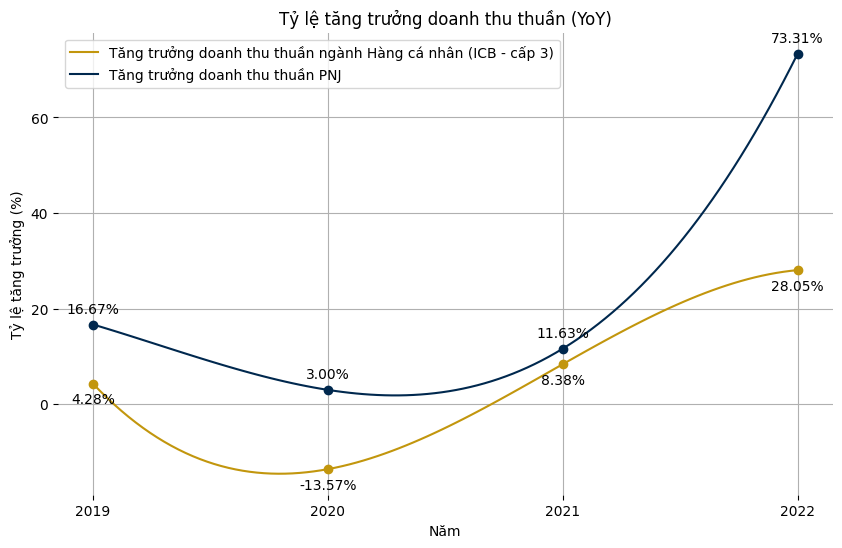

In [25]:
# Lấy giá trị cột chứa "KQKD. Doanh thu thuần" cho từng năm
column_name = "KQKD. Doanh thu thuần"
profits3 = []

for i, df in enumerate(dfs):
    year = 2018 + i
    matching_columns = df.filter(like=column_name)
    column_values2 = matching_columns[df["Ngành ICB - cấp 2"] == "Hàng cá nhân & Gia dụng"].iloc[:, 0].dropna().values
    mean_profit2 = np.mean(column_values2)
    profits3.append(mean_profit2)

# Tính toán tỷ lệ tăng trưởng YoY cho tổng quan
growth_rates3 = []
for i in range(1, len(profits3)):
    current_profit = profits3[i]
    previous_profit = profits3[i - 1]
    growth_rate3 = (current_profit - previous_profit) / previous_profit * 100
    growth_rates3.append(growth_rate3)

# Lấy giá trị lợi nhuận sau thuế của công ty PNJ cho từng năm
company_name = "PNJ"
pnj_profits3 = []

for i, df in enumerate(dfs):
    year = 2018 + i
    matching_columns = df.filter(like=column_name)
    column_values2 = matching_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_profits3.append(column_values2.values[0])

# Tính toán tỷ lệ tăng trưởng YoY cho công ty PNJ
pnj_growth_rates3 = []
for i in range(1, len(pnj_profits3)):
    current_profit = pnj_profits3[i]
    previous_profit = pnj_profits3[i - 1]
    growth_rate3 = (current_profit - previous_profit) / previous_profit * 100
    pnj_growth_rates3.append(growth_rate3)

# Tạo đường cong nội suy cho PNJ
years3 = range(2019, 2023)
smooth_years3 = np.linspace(min(years), max(years), num=100)
pnj_tck3 = splrep(years, pnj_growth_rates3, s=None)
pnj_smooth_growth_rates3 = splev(smooth_years3, pnj_tck3)

# Tạo đường cong nội suy cho tổng quan
years3 = range(2019, 2023)
smooth_years3 = np.linspace(min(years), max(years), num=100)
grow_tck3 = splrep(years3, growth_rates3, s=None)
smooth_growth_rates3 = splev(smooth_years3, grow_tck3)

# Tạo một hình mới với kích thước tùy chỉnh
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ tỷ lệ tăng trưởng YoY với đường cong uốn lượn và lưới
plt.plot(years, growth_rates3, 'o', color='#C2960D')
plt.plot(smooth_years, smooth_growth_rates3, label='Tăng trưởng doanh thu thuần ngành Hàng cá nhân (ICB - cấp 3)', color='#C2960D')
plt.plot(years, pnj_growth_rates3, 'o', color='#00284E')
plt.plot(smooth_years, pnj_smooth_growth_rates3, label='Tăng trưởng doanh thu thuần PNJ', color='#00284E')

plt.xticks(years)  # Tắt hiển thị các giá trị x nhỏ
plt.grid(True)  # Thêm lưới
plt.box(False)

plt.xlabel("Năm")
plt.ylabel("Tỷ lệ tăng trưởng (%)")
plt.title("Tỷ lệ tăng trưởng doanh thu thuần (YoY)")
plt.legend()

# Hiển thị phần trăm trên các chấm năm (Tổng quan)
for i in range(len(years)):
    plt.annotate(f"{growth_rates3[i]:.2f}%", (years[i], growth_rates3[i] - 4.8), ha='center', va='bottom')

# Hiển thị phần trăm trên các chấm năm (PNJ)
for i in range(len(years)):
    plt.annotate(f"{pnj_growth_rates3[i]:.2f}%", (years[i], pnj_growth_rates3[i] + 1.8), ha='center', va='bottom')

plt.show()

Tỷ số thanh khoản

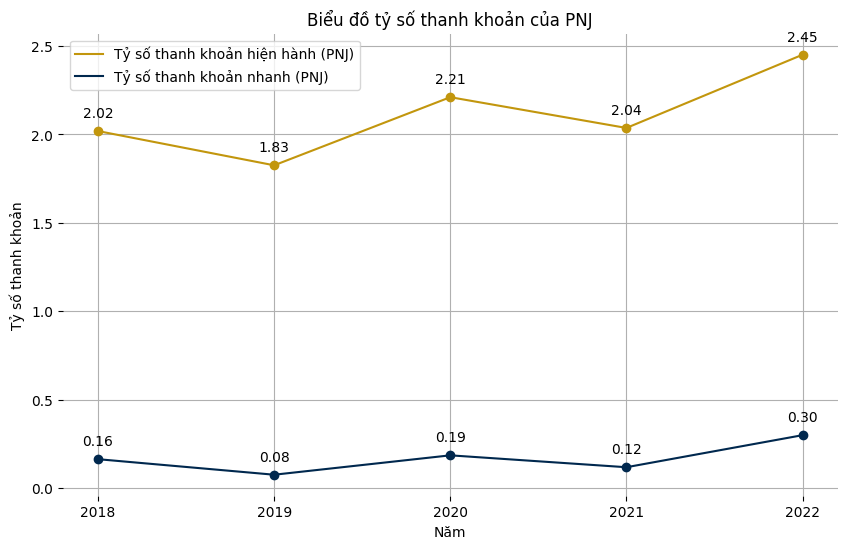

In [26]:
company_name = "PNJ"
short_term_assets_column = "CĐKT. TÀI SẢN NGẮN HẠN"
short_term_debt_column = "Nợ ngắn hạn"
inventory_column = "Hàng tồn kho"

pnj_short_term_assets = []
pnj_short_term_debt = []
pnj_inventory = []
years = []

for i, df in enumerate(dfs):
    year = 2018 + i
    years.append(year)
    
    matching_assets_columns = df.filter(like=short_term_assets_column)
    assets_column_values = matching_assets_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_short_term_assets.append(assets_column_values.values[0])

    matching_debt_columns = df.filter(like=short_term_debt_column)
    debt_column_values = matching_debt_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_short_term_debt.append(debt_column_values.values[0])

    matching_inventory_columns = df.filter(like=inventory_column)
    inventory_column_values = matching_inventory_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_inventory.append(inventory_column_values.values[0])

current_ratio = [assets / debt for assets, debt in zip(pnj_short_term_assets, pnj_short_term_debt)]
quick_ratio = [(assets - inventory) / debt for assets, inventory, debt in zip(pnj_short_term_assets, pnj_inventory, pnj_short_term_debt)]

plt.figure(figsize=(10, 6))
plt.plot(years, current_ratio, label='Tỷ số thanh khoản hiện hành (PNJ)', color='#C2960D', zorder=2)
plt.plot(years, quick_ratio, label='Tỷ số thanh khoản nhanh (PNJ)', color='#00284E', zorder=2)
plt.scatter(years, current_ratio, color='#C2960D', marker='o', zorder=3)
plt.scatter(years, quick_ratio, color='#00284E', marker='o', zorder=3)
plt.legend()
plt.title('Biểu đồ tỷ số thanh khoản của PNJ')
plt.xlabel('Năm')
plt.ylabel('Tỷ số thanh khoản')
plt.box(False)
plt.xticks(years)
plt.grid(True, zorder=0)

for year, cr, qr in zip(years, current_ratio, quick_ratio):
    plt.annotate(f'{cr:.2f}', (year, cr), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(f'{qr:.2f}', (year, qr), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

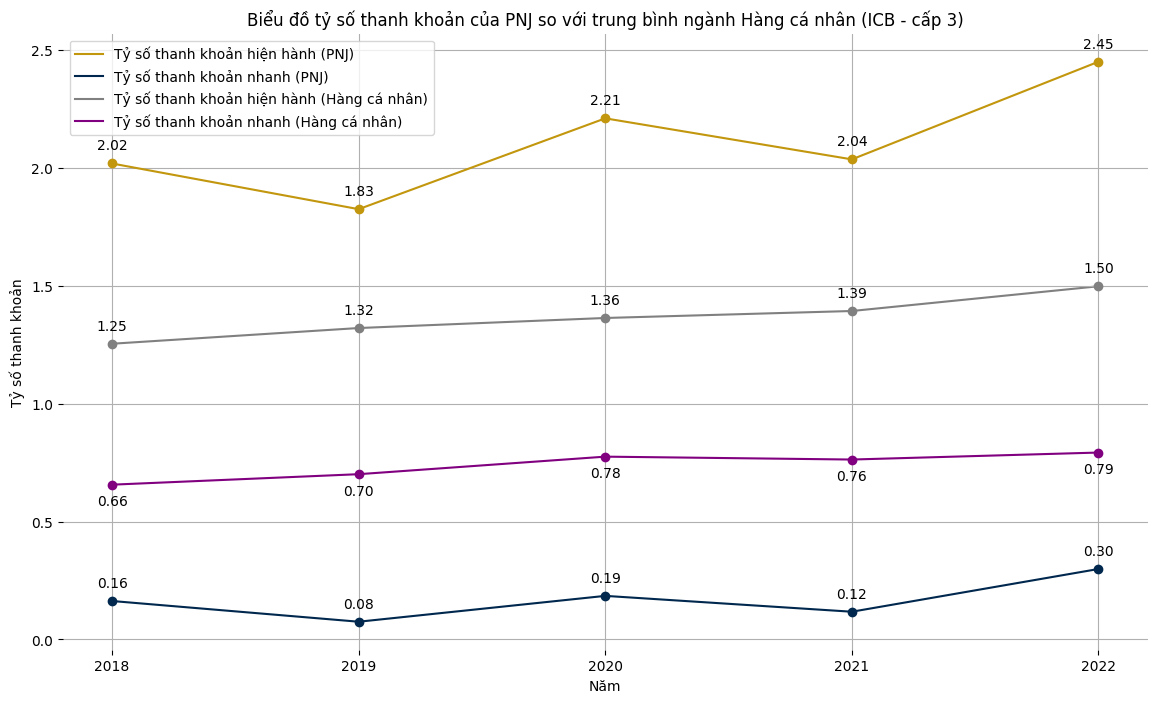

In [27]:
# Thông tin về công ty và cột tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho
company_name = "PNJ"
short_term_assets_column = "CĐKT. TÀI SẢN NGẮN HẠN"
short_term_debt_column = "Nợ ngắn hạn"
inventory_column = "Hàng tồn kho"

# Dữ liệu tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho
pnj_short_term_assets = []
pnj_short_term_debt = []
pnj_inventory = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i
    
    # Lấy giá trị tài sản ngắn hạn cho công ty
    matching_assets_columns = df.filter(like=short_term_assets_column)
    assets_column_values = matching_assets_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_short_term_assets.append(assets_column_values.values[0])

    # Lấy giá trị nợ ngắn hạn cho công ty
    matching_debt_columns = df.filter(like=short_term_debt_column)
    debt_column_values = matching_debt_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_short_term_debt.append(debt_column_values.values[0])

    # Lấy giá trị hàng tồn kho cho công ty
    matching_inventory_columns = df.filter(like=inventory_column)
    inventory_column_values = matching_inventory_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_inventory.append(inventory_column_values.values[0])

# Tính chỉ số thanh khoản hiện hành và chỉ số thanh khoản nhanh
current_ratio = [assets / debt for assets, debt in zip(pnj_short_term_assets, pnj_short_term_debt)]
quick_ratio = [(assets - inventory) / debt for assets, inventory, debt in zip(pnj_short_term_assets, pnj_inventory, pnj_short_term_debt)]

# Thông tin về công ty và cột tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho
short_term_assets_column = "CĐKT. TÀI SẢN NGẮN HẠN"
short_term_debt_column = "Nợ ngắn hạn"
inventory_column = "Hàng tồn kho"

# Dữ liệu tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho
short_term_assets = []
short_term_debt = []
inventory = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i
    
    # Lấy giá trị tài sản ngắn hạn cho công ty
    matching_assets_columns = df.filter(like=short_term_assets_column)
    assets_column_values = matching_assets_columns[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean4 = np.mean(assets_column_values)
    short_term_assets.append(mean4)

    # Lấy giá trị nợ ngắn hạn cho công ty
    matching_debt_columns = df.filter(like=short_term_debt_column)
    debt_column_values = matching_debt_columns[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean5 = np.mean(debt_column_values)
    short_term_debt.append(mean5)

    # Lấy giá trị hàng tồn kho cho công ty
    matching_inventory_columns = df.filter(like=inventory_column)
    inventory_column_values = matching_inventory_columns[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean6 = np.mean(inventory_column_values)
    inventory.append(mean6)
    
current_ratio2 = [assets / debt for assets, debt in zip(short_term_assets, short_term_debt)]
quick_ratio2 = [(assets - inventory) / debt for assets, inventory, debt in zip(short_term_assets, inventory, short_term_debt)]
# Tạo một hình ảnh mới với kích thước lớn hơn
plt.figure(figsize=(14, 8))

# Vẽ biểu đồ chỉ số thanh khoản hiện hành và chỉ số thanh khoản nhanh của PNJ
plt.plot(years, current_ratio, label='Tỷ số thanh khoản hiện hành (PNJ)', color='#C2960D', zorder=2)
plt.plot(years, quick_ratio, label='Tỷ số thanh khoản nhanh (PNJ)', color='#00284E', zorder=2)

# Vẽ biểu đồ chỉ số thanh khoản hiện hành và chỉ số thanh khoản nhanh của hàng tiêu dùng
plt.plot(years, current_ratio2, label='Tỷ số thanh khoản hiện hành (Hàng cá nhân)', color='gray', zorder=1)
plt.plot(years, quick_ratio2, label='Tỷ số thanh khoản nhanh (Hàng cá nhân)', color='#800080', zorder=1)

plt.scatter(years, current_ratio, color='#C2960D', marker='o', zorder=3)
plt.scatter(years, quick_ratio, color='#00284E', marker='o', zorder=3)
plt.scatter(years, current_ratio2, color='gray', marker='o', zorder=3)
plt.scatter(years, quick_ratio2, color='#800080', marker='o', zorder=3)

# Hiển thị chú thích
plt.legend()

# Đặt tiêu đề biểu đồ
plt.title('Biểu đồ tỷ số thanh khoản của PNJ so với trung bình ngành Hàng cá nhân (ICB - cấp 3)')

# Đặt nhãn cho trục x
plt.xlabel('Năm')

# Đặt nhãn cho trục y (tay trái)
plt.ylabel('Tỷ số thanh khoản')

# Xóa khung viền
plt.box(False)

# Xóa số thập phân và hiển thị số nguyên ở mỗi năm
plt.xticks(years)

# Hiển thị lưới
plt.grid(True, zorder=0)

# Hiển thị số tính toán ở mỗi năm cho PNJ
for year, cr, qr in zip(years, current_ratio, quick_ratio):
    plt.annotate(f'{cr:.2f}', (year, cr), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{qr:.2f}', (year, qr), textcoords="offset points", xytext=(0,10), ha='center')

# Hiển thị số tính toán ở mỗi năm cho hàng tiêu dùng
for year, cr2, qr2 in zip(years, current_ratio2, quick_ratio2):
    plt.annotate(f'{cr2:.2f}', (year, cr2), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{qr2:.2f}', (year, qr2), textcoords="offset points", xytext=(0,- 15), ha='center')

plt.show()


Tỷ số khả năng sinh lời

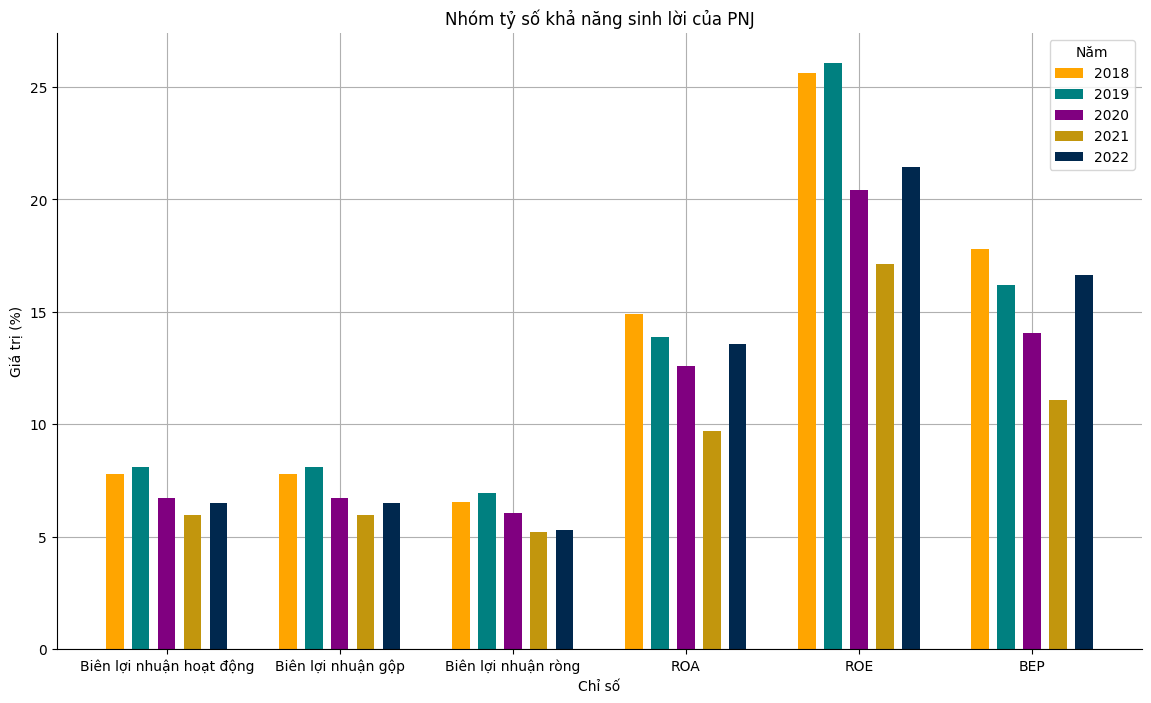

In [28]:
#PNJ
# Tên công ty
company_name = "PNJ"

# Các cột chỉ tiêu KQKD
interest_expenses_column = "Chi phí lãi vay"
pre_tax_profit_column = "KQKD. Tổng lợi nhuận kế toán trước thuế"
revenue_column = "KQKD. Doanh thu bán hàng và cung cấp dịch vụ"

# Các cột chỉ tiêu tài sản và vốn
short_term_assets_column = "CĐKT. TÀI SẢN NGẮN HẠN"
long_term_assets_column = "CĐKT. TÀI SẢN DÀI HẠN"
equity_column = "CĐKT. VỐN CHỦ SỞ HỮU"
profit_aftertax_column = 'KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp'

# Dữ liệu KQKD và chỉ tiêu tài sản và vốn
pnj_interest_expenses = []
pnj_pre_tax_profit = []
pnj_revenue = []
pnj_short_term_assets = []
pnj_long_term_assets = []
pnj_equity = []
pnj_profit_aftertax = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i
    
    # Lấy giá trị tài sản ngắn hạn cho công ty
    matching_assets_columns = df.filter(like=short_term_assets_column)
    assets_column_values = matching_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_short_term_assets.append(assets_column_values.values[0])

    # Lấy giá trị tài sản dài hạn cho công ty
    matching_long_term_assets_columns = df.filter(like=long_term_assets_column)
    long_term_assets_values = matching_long_term_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_long_term_assets.append(long_term_assets_values.values[0])

    # Lấy giá trị vốn chủ sở hữu
    matching_equity_columns = df.filter(like=equity_column)
    equity_column_values = matching_equity_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_equity.append(equity_column_values.values[0])

    # Lấy giá trị tổng lợi nhuận kế toán trước thuế
    matching_taxprofit_columns = df.filter(like=pre_tax_profit_column)
    taxprofit_column_values = matching_taxprofit_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_pre_tax_profit.append(taxprofit_column_values.values[0])

    # Lấy giá trị chi phí lãi vay
    matching_interest_columns = df.filter(like=interest_expenses_column)
    interest_column_values = matching_interest_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_interest_expenses.append(interest_column_values.values[0])

    # Lấy giá trị Doanh thu bán hàng và cung cấp dịch vụ
    matching_revenue_columns = df.filter(like=revenue_column)
    revenue_column_values = matching_revenue_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_revenue.append(revenue_column_values.values[0])

    # Lấy giá trị Lợi nhuận sau thuế thu nhập doanh nghiệp
    matching_profit_after_tax_columns = df.filter(like=profit_aftertax_column)
    profit_after_tax_column_values = matching_profit_after_tax_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_profit_aftertax.append(profit_after_tax_column_values.values[0])

# Tính tổng lợi nhuận kế toán trước thuế và lãi vay
pnj_total_profit_and_interest = [profit + interest for profit, interest in zip(pnj_pre_tax_profit, pnj_interest_expenses)]

# Tính tổng tài sản
pnj_total_assets = [short_term + long_term for short_term, long_term in zip(pnj_short_term_assets, pnj_long_term_assets)]

# Tính biên lợi nhuận hoạt động
operating_profit_margin = [(profit / revenue) * 100  for profit, revenue in zip(pnj_total_profit_and_interest, pnj_revenue)]

# Tính biên lợi nhuận gộp
gross_profit_margin = [(gross_profit / revenue)*100 for gross_profit, revenue in zip(pnj_total_profit_and_interest, pnj_revenue)]

# Tính biên lợi nhuận ròng
net_profit_margin = [(net_profit / revenue)*100 for net_profit, revenue in zip(pnj_profit_aftertax, pnj_revenue)]

# Tính ROA
roa = [(net_profit / total_assets)*100 for net_profit, total_assets in zip(pnj_profit_aftertax, pnj_total_assets)]

# Tính ROE
roe = [(net_profit / equity)*100 for net_profit, equity in zip(pnj_profit_aftertax, pnj_equity)]

#Tính BEP
bep = [(profit / total_assets)*100 for profit, total_assets in zip(pnj_total_profit_and_interest, pnj_total_assets)]

# Dữ liệu năm
years = range(2018, 2018 + len(dfs))

data = [operating_profit_margin, gross_profit_margin, net_profit_margin, roa, roe, bep]
labels = ["Biên lợi nhuận hoạt động", "Biên lợi nhuận gộp", "Biên lợi nhuận ròng", "ROA", "ROE", "BEP"]

# Các thông số cho biểu đồ
bar_width = 0.1
spacing = 0.05
x_pos = np.arange(len(labels))

# Mã màu cho các cột
color_palette = ['#FFA500', '#008080', '#800080', '#C2960D', '#00284E', 'gray']

# Vẽ biểu đồ cột dạng kép
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(years)):
    ax.bar(x_pos + (i * (bar_width + spacing)), [data[j][i] for j in range(len(data))], width=bar_width, label=str(years[i]), color=color_palette[i])

ax.set_xlabel("Chỉ số")
ax.set_ylabel("Giá trị (%)")
ax.set_title("Nhóm tỷ số khả năng sinh lời của PNJ")
ax.set_xticks(x_pos + ((len(years) - 1) / 2) * (bar_width + spacing))
ax.set_xticklabels(labels)
ax.legend(title="Năm")

# Xóa khung viền
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hiển thị lưới
ax.grid(True)
ax.set_axisbelow(True)  # Lưới được đặt chìm phía sau cột

# Điều chỉnh kích thước biểu đồ
fig.set_size_inches(14, 8)  # Điều chỉnh kích thước ở đây (12 là chiều rộng, 8 là chiều cao)

plt.show()

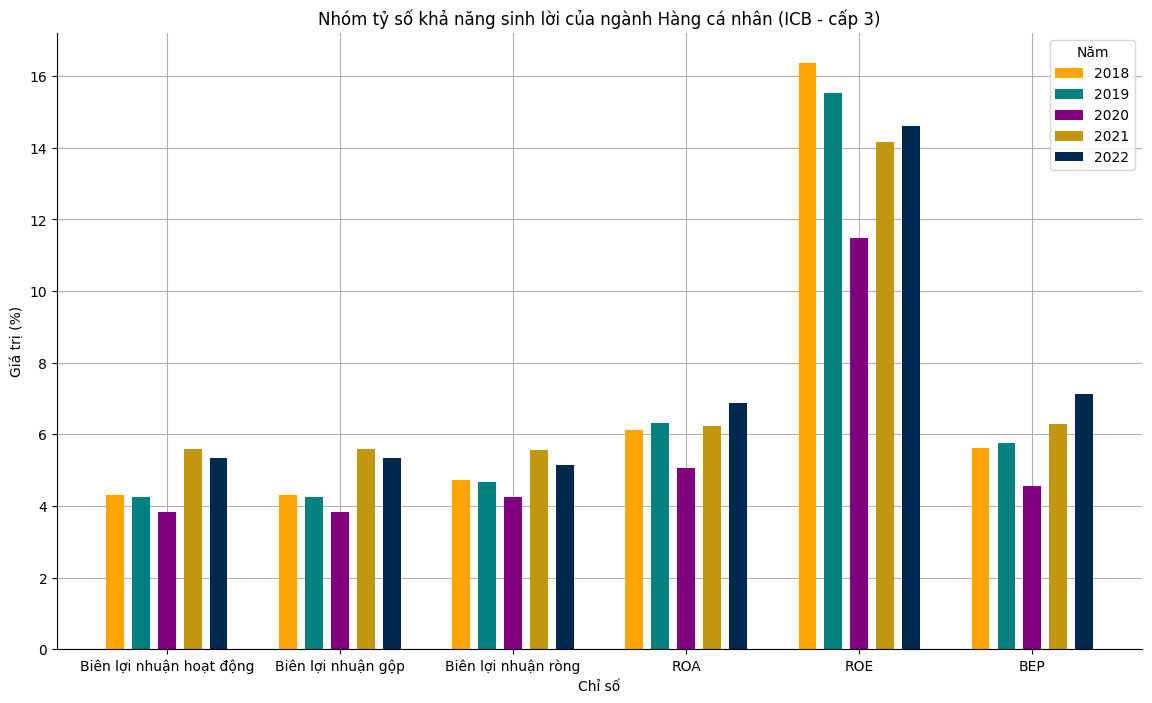

In [29]:
#-----Ngành
# Tên công ty
company_name = "PNJ"

# Các cột chỉ tiêu KQKD
interest_expenses_column = "Chi phí lãi vay"
pre_tax_profit_column = "KQKD. Tổng lợi nhuận kế toán trước thuế"
revenue_column = "KQKD. Doanh thu bán hàng và cung cấp dịch vụ"

# Các cột chỉ tiêu tài sản và vốn
short_term_assets_column = "CĐKT. TÀI SẢN NGẮN HẠN"
long_term_assets_column = "CĐKT. TÀI SẢN DÀI HẠN"
equity_column = "CĐKT. VỐN CHỦ SỞ HỮU"
profit_aftertax_column = 'KQKD. Lợi nhuận sau thuế thu nhập doanh nghiệp'

# Dữ liệu KQKD và chỉ tiêu tài sản và vốn
interest_expenses = []
pre_tax_profit = []
revenue = []
short_term_assets = []
long_term_assets = []
equity = []
profit_aftertax = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i
    
    # Lấy giá trị tài sản ngắn hạn cho công ty
    matching_assets_columns = df.filter(like=short_term_assets_column)
    assets_column_values = matching_assets_columns[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean7= np.mean(assets_column_values)
    short_term_assets.append(mean7)

    # Lấy giá trị tài sản dài hạn cho công ty
    matching_long_term_assets_columns = df.filter(like=long_term_assets_column)
    long_term_assets_values = matching_long_term_assets_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean8= np.mean(long_term_assets_values)
    long_term_assets.append(mean8)

    # Lấy giá trị vốn chủ sở hữu
    matching_equity_columns = df.filter(like=equity_column)
    equity_column_values = matching_equity_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean9= np.mean(equity_column_values)
    equity.append(mean9)

    # Lấy giá trị tổng lợi nhuận kế toán trước thuế
    matching_taxprofit_columns = df.filter(like=pre_tax_profit_column)
    taxprofit_column_values = matching_taxprofit_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean10= np.mean(taxprofit_column_values)
    pre_tax_profit.append(mean10)

    # Lấy giá trị chi phí lãi vay
    matching_interest_columns = df.filter(like=interest_expenses_column)
    interest_column_values = matching_interest_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean11= np.mean(interest_column_values)
    interest_expenses.append(mean11)

    # Lấy giá trị Doanh thu bán hàng và cung cấp dịch vụ
    matching_revenue_columns = df.filter(like=revenue_column)
    revenue_column_values = matching_revenue_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean12= np.mean(revenue_column_values)
    revenue.append(mean12)

    # Lấy giá trị Lợi nhuận sau thuế thu nhập doanh nghiệp
    matching_profit_after_tax_columns = df.filter(like=profit_aftertax_column)
    profit_after_tax_column_values = matching_profit_after_tax_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0]
    mean13= np.mean(profit_after_tax_column_values)
    profit_aftertax.append(mean13)

# Tính tổng lợi nhuận kế toán trước thuế và lãi vay
total_profit_and_interest2 = [profit + interest for profit, interest in zip(pre_tax_profit, interest_expenses)]

# Tính tổng tài sản
total_assets2 = [short_term + long_term for short_term, long_term in zip(short_term_assets, long_term_assets)]

# Tính biên lợi nhuận hoạt động
operating_profit_margin2 = [(profit / revenue) * 100  for profit, revenue in zip(total_profit_and_interest2, revenue)]

# Tính biên lợi nhuận gộp
gross_profit_margin2 = [(gross_profit / revenue)*100 for gross_profit, revenue in zip(total_profit_and_interest2, revenue)]

# Tính biên lợi nhuận ròng
net_profit_margin2 = [(net_profit / revenue)*100 for net_profit, revenue in zip(profit_aftertax, revenue)]

# Tính ROA
roa2 = [(net_profit / total_assets)*100 for net_profit, total_assets in zip(profit_aftertax, total_assets2)]

# Tính ROE
roe2 = [(net_profit / equity)*100 for net_profit, equity in zip(profit_aftertax, equity)]

#Tính BEP
bep2 = [(profit / total_assets)*100 for profit, total_assets in zip(total_profit_and_interest2, total_assets2)]

# Dữ liệu năm
years = range(2018, 2018 + len(dfs))

data = [operating_profit_margin2, gross_profit_margin2, net_profit_margin2, roa2, roe2, bep2]
labels = ["Biên lợi nhuận hoạt động", "Biên lợi nhuận gộp", "Biên lợi nhuận ròng", "ROA", "ROE", "BEP"]

# Các thông số cho biểu đồ
bar_width = 0.1
spacing = 0.05
x_pos = np.arange(len(labels))

# Mã màu cho các cột
color_palette = ['#FFA500', '#008080', '#800080', '#C2960D', '#00284E', 'gray']

# Vẽ biểu đồ cột dạng kép
fig, ax = plt.subplots(figsize=(12, 8))
for i in range(len(years)):
    ax.bar(x_pos + (i * (bar_width + spacing)), [data[j][i] for j in range(len(data))], width=bar_width, label=str(years[i]), color=color_palette[i])

ax.set_xlabel("Chỉ số")
ax.set_ylabel("Giá trị (%)")
ax.set_title("Nhóm tỷ số khả năng sinh lời của ngành Hàng cá nhân (ICB - cấp 3)")
ax.set_xticks(x_pos + ((len(years) - 1) / 2) * (bar_width + spacing))
ax.set_xticklabels(labels)
ax.legend(title="Năm")

# Xóa khung viền
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hiển thị lưới
ax.grid(True)
ax.set_axisbelow(True)  # Lưới được đặt chìm phía sau cột

# Điều chỉnh kích thước biểu đồ
fig.set_size_inches(14, 8)  # Điều chỉnh kích thước ở đây (12 là chiều rộng, 8 là chiều cao)

plt.show()

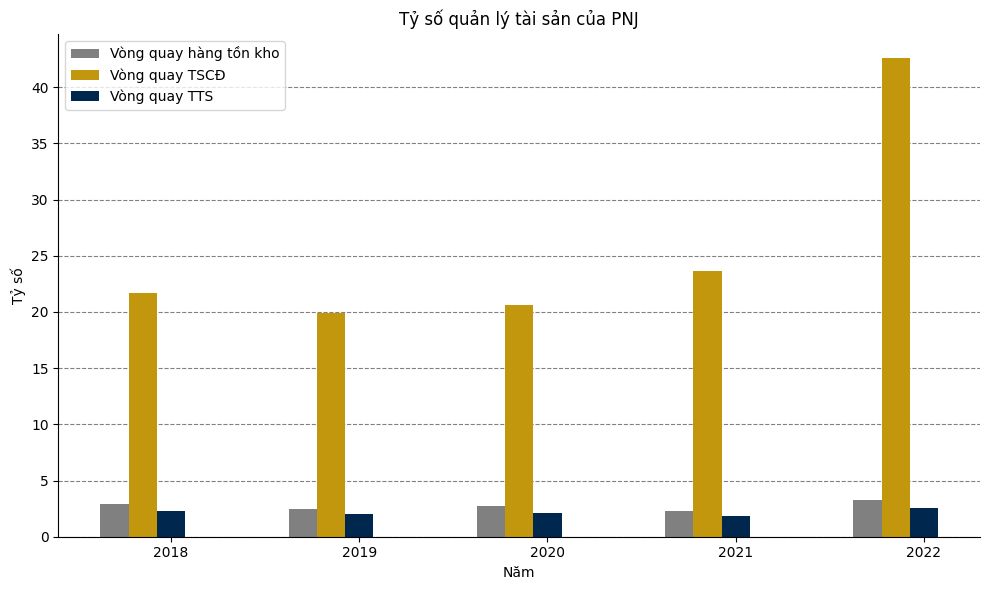

In [30]:
# Thông tin về công ty và cột tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho
company_name = "PNJ"
short_term_assets_column = "CĐKT. TÀI SẢN NGẮN HẠN"
inventory_column = "Hàng tồn kho"
long_term_assets_column = "CĐKT. TÀI SẢN DÀI HẠN"
revenue_column = "KQKD. Doanh thu bán hàng và cung cấp dịch vụ"
khauhao_column = "LCTT. Khấu hao TSCĐ"
tscd_column = "CĐKT. Tài sản cố định"


# Dữ liệu tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho
pnj_short_term_assets = []
pnj_short_term_debt = []
pnj_inventory = []
pnj_long_term_assets = []
pnj_revenue = []
pnj_khauhao = []
pnj_tscd = []


# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i
    
    # Lấy giá trị tài sản ngắn hạn cho công ty
    matching_assets_columns = df.filter(like=short_term_assets_column)
    assets_column_values = matching_assets_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_short_term_assets.append(assets_column_values.values[0])

    # Lấy giá trị tài sản dài hạn cho công ty
    matching_long_term_assets_columns = df.filter(like=long_term_assets_column)
    long_term_assets_values = matching_long_term_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_long_term_assets.append(long_term_assets_values.values[0])

    # Lấy giá trị hàng tồn kho cho công ty
    matching_inventory_columns = df.filter(like=inventory_column)
    inventory_column_values = matching_inventory_columns[df["Mã"] == company_name].iloc[:, 0]
    pnj_inventory.append(inventory_column_values.values[0])

    # Lấy giá trị Doanh thu bán hàng và cung cấp dịch vụ
    matching_revenue_columns = df.filter(like=revenue_column)
    revenue_column_values = matching_revenue_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_revenue.append(revenue_column_values.values[0])

    # Lấy giá trị khấu hao
    matching_khauhao_columns = df.filter(like=khauhao_column)
    khauhao_column_values = matching_khauhao_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_khauhao.append(khauhao_column_values.values[0])

    # Lấy giá trị tài sản cố định
    matching_tscd_columns = df.filter(like=tscd_column)
    tscd_column_values = matching_tscd_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_tscd.append(tscd_column_values.values[0])

# Tính tổng tài sản
total_assets = [short_assets + long_assets for short_assets, long_assets in zip(pnj_short_term_assets, pnj_long_term_assets)]

# Tính tài sản cố định ròng
net_fixed_assets = [tscd - khau_hao for tscd, khau_hao in zip(pnj_tscd, pnj_khauhao)]

# Tính tỷ số vòng quay hàng tồn kho
pnj_inventory_turnover_ratio = [revenue / inventory for revenue, inventory in zip(pnj_revenue, pnj_inventory)]

# Tính tỷ số vòng quay TSCĐ
pnj_fixed_assets_turnover_ratio = [revenue / net_fixed_asset for revenue, net_fixed_asset in zip(pnj_revenue, net_fixed_assets)]

# Tính tỷ số vòng quay TTS
pnj_total_assets_turnover_ratio = [revenue / total_asset for revenue, total_asset in zip(pnj_revenue, total_assets)]
# Tạo danh sách năm từ 2018 đến hiện tại
years = np.arange(2018, 2018 + len(dfs))

index_labels = ['Vòng quay hàng tồn kho', 'Vòng quay TSCĐ', 'Vòng quay TTS']
data = [pnj_inventory_turnover_ratio, pnj_fixed_assets_turnover_ratio, pnj_total_assets_turnover_ratio]

# Mã màu cho các cột
color_palette = ['gray', '#C2960D', '#00284E']

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15
opacity = 1

for i, d in enumerate(data):
    x = np.arange(len(years))
    y = d
    ax.bar(x + i * bar_width, y, bar_width, alpha=opacity, label=index_labels[i], color=color_palette[i])

ax.set_xlabel('Năm')
ax.set_ylabel('Tỷ số')
ax.set_title('Tỷ số quản lý tài sản của PNJ')
ax.set_xticks(x + bar_width * 2)
ax.set_xticklabels(years)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

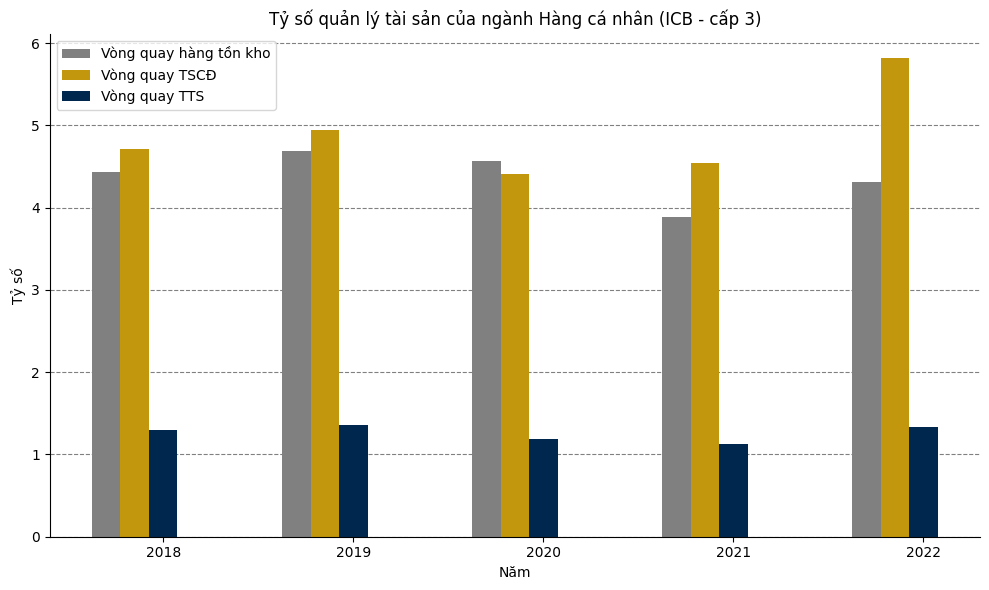

In [31]:
# Thông tin về công ty và cột tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho

short_term_assets_column = "CĐKT. TÀI SẢN NGẮN HẠN"
inventory_column = "Hàng tồn kho"
long_term_assets_column = "CĐKT. TÀI SẢN DÀI HẠN"
revenue_column = "KQKD. Doanh thu bán hàng và cung cấp dịch vụ"
khauhao_column = "LCTT. Khấu hao TSCĐ"
tscd_column = "CĐKT. Tài sản cố định"


# Dữ liệu tài sản ngắn hạn, nợ ngắn hạn, hàng tồn kho
short_term_assets = []
short_term_debt = []
inventory = []
long_term_assets = []
revenue = []
khauhao = []
tscd = []


# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i
    
    # Lấy giá trị tài sản ngắn hạn cho công ty
    matching_assets_columns = df.filter(like=short_term_assets_column)
    assets_column_values = matching_assets_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean15= np.mean(assets_column_values)
    short_term_assets.append(mean15)

    # Lấy giá trị tài sản dài hạn cho công ty
    matching_long_term_assets_columns = df.filter(like=long_term_assets_column)
    long_term_assets_values = matching_long_term_assets_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean16= np.mean(long_term_assets_values)
    long_term_assets.append(mean16)

    # Lấy giá trị hàng tồn kho cho công ty
    matching_inventory_columns = df.filter(like=inventory_column)
    inventory_column_values = matching_inventory_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean17= np.mean(inventory_column_values)
    inventory.append(mean17)

    # Lấy giá trị Doanh thu bán hàng và cung cấp dịch vụ
    matching_revenue_columns = df.filter(like=revenue_column)
    revenue_column_values = matching_revenue_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean18= np.mean(revenue_column_values)
    revenue.append(mean18)

    # Lấy giá trị khấu hao
    matching_khauhao_columns = df.filter(like=khauhao_column)
    khauhao_column_values = matching_khauhao_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean19= np.mean(khauhao_column_values)
    khauhao.append(mean19)

    # Lấy giá trị tài sản cố định
    matching_tscd_columns = df.filter(like=tscd_column)
    tscd_column_values = matching_tscd_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean20= np.mean(tscd_column_values)
    tscd.append(mean20)

# Tính tổng tài sản
total_assets = [short_assets + long_assets for short_assets, long_assets in zip(short_term_assets, long_term_assets)]

# Tính tài sản cố định ròng
net_fixed_assets = [tscd - khau_hao for tscd, khau_hao in zip(tscd, khauhao)]

# Tính tỷ số vòng quay hàng tồn kho
inventory_turnover_ratio = [revenue / inventory for revenue, inventory in zip(revenue, inventory)]

# Tính tỷ số vòng quay TSCĐ
fixed_assets_turnover_ratio = [revenue / tscd for revenue, tscd in zip(revenue, tscd)]

# Tính tỷ số vòng quay TTS
total_assets_turnover_ratio = [revenue / total_asset for revenue, total_asset in zip(revenue, total_assets)]

# Tạo danh sách năm từ 2018 đến hiện tại
years = np.arange(2018, 2018 + len(dfs))

# Tạo list chỉ số để hiển thị trên trục hoành
index_labels = ['Vòng quay hàng tồn kho', 'Vòng quay TSCĐ', 'Vòng quay TTS']

# Tạo list dữ liệu cột cho từng chỉ số
data = [inventory_turnover_ratio, fixed_assets_turnover_ratio, total_assets_turnover_ratio]
index_labels = ['Vòng quay hàng tồn kho', 'Vòng quay TSCĐ', 'Vòng quay TTS']

# Mã màu cho các cột
color_palette = ['gray', '#C2960D', '#00284E']

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15
opacity = 1

for i, d in enumerate(data):
    x = np.arange(len(years))
    y = d
    ax.bar(x + i * bar_width, y, bar_width, alpha=opacity, label=index_labels[i], color=color_palette[i])

ax.set_xlabel('Năm')
ax.set_ylabel('Tỷ số')
ax.set_title('Tỷ số quản lý tài sản của ngành Hàng cá nhân (ICB - cấp 3)')
ax.set_xticks(x + bar_width * 2)
ax.set_xticklabels(years)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()


Tỷ số quản trị nợ

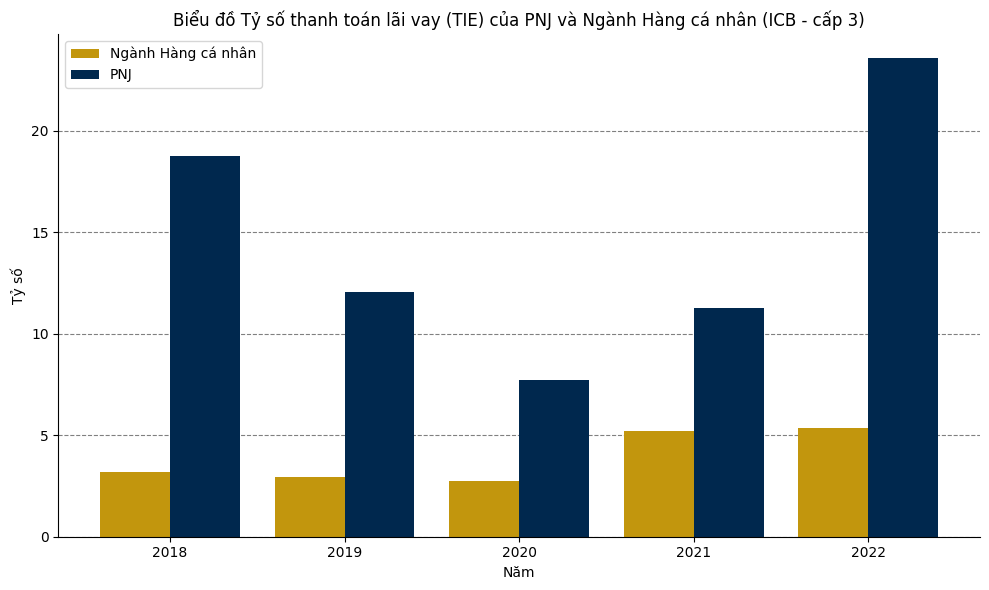

In [32]:
# Tên công ty
company_name = "PNJ"

# Các cột chỉ tiêu KQKD
interest_expenses_column = "Chi phí lãi vay"
pre_tax_profit_column = "KQKD. Tổng lợi nhuận kế toán trước thuế"
equity_column = "CĐKT. VỐN CHỦ SỞ HỮU"
short_debt_column = "CĐKT. Vay và nợ thuê tài chính ngắn hạn"
long_debt_column = "CĐKT. Vay và nợ thuê tài chính dài hạn"

# Dữ liệu KQKD và chỉ tiêu tài sản và vốn
pnj_interest_expenses = []
pnj_pre_tax_profit = []
pnj_revenue = []
pnj_equity = []
pnj_short_debt = []
pnj_long_debt = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i

    # Lấy giá trị vốn chủ sở hữu
    matching_equity_columns = df.filter(like=equity_column)
    equity_column_values = matching_equity_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_equity.append(equity_column_values.values[0])

    #Lấy giá trị tổng lợi nhuận kế toán trước thuế
    matching_taxprofit_columns = df.filter(like=pre_tax_profit_column)
    taxprofit_column_values = matching_taxprofit_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_pre_tax_profit.append(taxprofit_column_values.values[0])

    # Lấy giá trị chi phí lãi vay
    matching_interest_columns = df.filter(like=interest_expenses_column)
    interest_column_values = matching_interest_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_interest_expenses.append(interest_column_values.values[0])

    # Lấy giá trị vay ngắn hạn
    matching_shortdebt_columns = df.filter(like=short_debt_column)
    shortdebt_column_values = matching_shortdebt_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_short_debt.append(shortdebt_column_values.values[0])

    # Lấy giá trị vay dài hạn
    matching_longdebt_columns = df.filter(like=long_debt_column)
    longdebt_column_values = matching_longdebt_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_long_debt.append(longdebt_column_values.values[0])


# Tính tổng lợi nhuận kế toán trước thuế và lãi vay
pnj_total_profit_and_interest = [profit + interest for profit, interest in zip(pnj_pre_tax_profit, pnj_interest_expenses)]

# Tính giá trị tổng vay
pnj_total_debt = [short_debt + long_debt for short_debt, long_debt in zip(pnj_short_debt, pnj_long_debt)]

# Tính Tỷ số thanh toán lãi vay (TIE)
pnj_tie = [pnj_total_profit_and_interest / interest for pnj_total_profit_and_interest, interest in zip(pnj_total_profit_and_interest, pnj_interest_expenses)]

# Tính Tỷ lệ nợ vay trên tổng vốn
pnj_debt_to_equity_ratio = [debt / (debt + equity) for debt, equity in zip(pnj_total_debt, pnj_equity)]

#NGÀNH

# Các cột chỉ tiêu KQKD
interest_expenses_column = "Chi phí lãi vay"
pre_tax_profit_column = "KQKD. Tổng lợi nhuận kế toán trước thuế"
equity_column = "CĐKT. VỐN CHỦ SỞ HỮU"
short_debt_column = "CĐKT. Vay và nợ thuê tài chính ngắn hạn"
long_debt_column = "CĐKT. Vay và nợ thuê tài chính dài hạn"

# Dữ liệu KQKD và chỉ tiêu tài sản và vốn
interest_expenses = []
pre_tax_profit = []
revenue = []
equity = []
short_debt = []
long_debt = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i

    # Lấy giá trị vốn chủ sở hữu
    matching_equity_columns = df.filter(like=equity_column)
    equity_column_values = matching_equity_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean17= np.mean(equity_column_values)
    equity.append(mean17)

    #Lấy giá trị tổng lợi nhuận kế toán trước thuế
    matching_taxprofit_columns = df.filter(like=pre_tax_profit_column)
    taxprofit_column_values = matching_taxprofit_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean18= np.mean(taxprofit_column_values)
    pre_tax_profit.append(mean18)

    # Lấy giá trị chi phí lãi vay
    matching_interest_columns = df.filter(like=interest_expenses_column)
    interest_column_values = matching_interest_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean19= np.mean(interest_column_values)
    interest_expenses.append(mean19)

    # Lấy giá trị vay ngắn hạn
    matching_shortdebt_columns = df.filter(like=short_debt_column)
    shortdebt_column_values = matching_shortdebt_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0].dropna().values
    mean20= np.mean(shortdebt_column_values)
    short_debt.append(mean20)

    # Lấy giá trị vay dài hạn
    matching_longdebt_columns = df.filter(like=long_debt_column)
    longdebt_column_values = matching_longdebt_columns.loc[df["Ngành ICB - cấp 3"] == "Hàng cá nhân"].iloc[:, 0]
    mean21= np.mean(longdebt_column_values)
    long_debt.append(mean21)


# Tính tổng lợi nhuận kế toán trước thuế và lãi vay
total_profit_and_interest = [profit + interest for profit, interest in zip(pre_tax_profit, interest_expenses)]

# Tính giá trị tổng vay
total_debt = [short_debt + long_debt for short_debt, long_debt in zip(short_debt, long_debt)]

# Tính Tỷ số thanh toán lãi vay (TIE)
tie = [total_profit_and_interest / interest for total_profit_and_interest, interest in zip(total_profit_and_interest, interest_expenses)]

# Tính Tỷ lệ nợ vay trên tổng vốn
debt_to_equity_ratio = [debt / (debt + equity) for debt, equity in zip(total_debt, equity)]

# Tạo danh sách năm từ 2018 đến hiện tại
years = np.arange(2018, 2018 + len(dfs))

# Tạo list chỉ số để hiển thị trên trục hoành
index_labels = ['Ngành Hàng cá nhân', 'PNJ']

# Tạo list dữ liệu cột cho TIE của từng chỉ số
data = [tie, pnj_tie]

# Lấy giá trị tuyệt đối cho các giá trị trong data
data = [np.abs(d) for d in data]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
opacity = 1

# Mã màu cho các cột
color_palette = ['#C2960D', '#00284E']

for i, d in enumerate(data):
    x = np.arange(len(years))
    y = d
    ax.bar(x + i * bar_width, y, bar_width, alpha=opacity, label=index_labels[i], color=color_palette[i])

ax.set_xlabel('Năm')
ax.set_ylabel('Tỷ số')
ax.set_title('Biểu đồ Tỷ số thanh toán lãi vay (TIE) của PNJ và Ngành Hàng cá nhân (ICB - cấp 3)')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(years)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

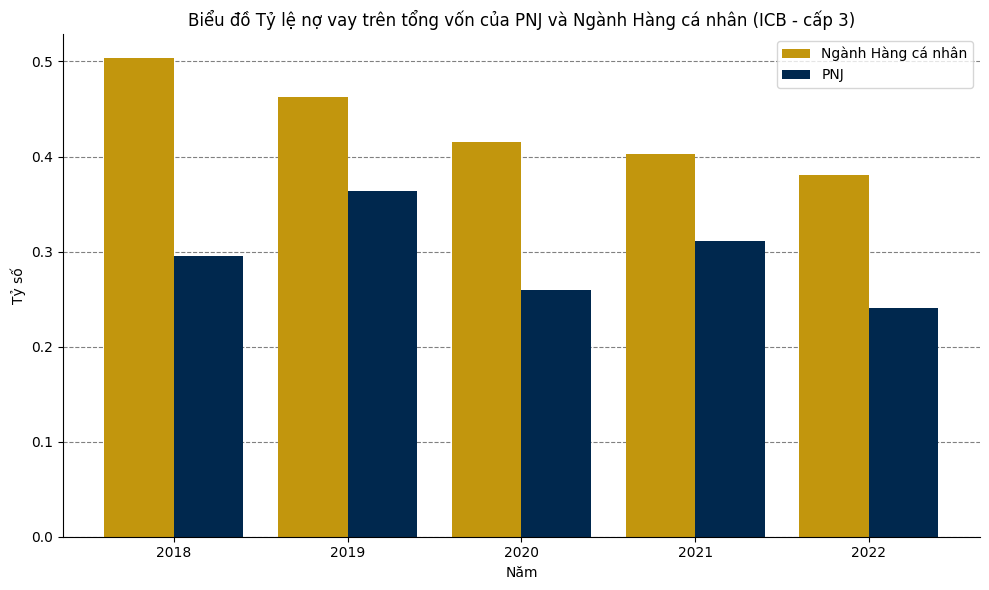

In [33]:
# Tạo danh sách năm từ 2018 đến hiện tại
years = np.arange(2018, 2018 + len(dfs))

# Tạo list chỉ số để hiển thị trên trục hoành
index_labels = ['Ngành Hàng cá nhân', 'PNJ']

# Tạo list dữ liệu cột cho TIE của từng chỉ số
data = [debt_to_equity_ratio, pnj_debt_to_equity_ratio]

# Lấy giá trị tuyệt đối cho các giá trị trong data
data = [np.abs(d) for d in data]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
opacity = 1

# Mã màu cho các cột
color_palette = ['#C2960D', '#00284E']

for i, d in enumerate(data):
    x = np.arange(len(years))
    y = d
    ax.bar(x + i * bar_width, y, bar_width, alpha=opacity, label=index_labels[i], color=color_palette[i])

ax.set_xlabel('Năm')
ax.set_ylabel('Tỷ số')
ax.set_title('Biểu đồ Tỷ lệ nợ vay trên tổng vốn của PNJ và Ngành Hàng cá nhân (ICB - cấp 3)')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(years)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

Quản lý vốn

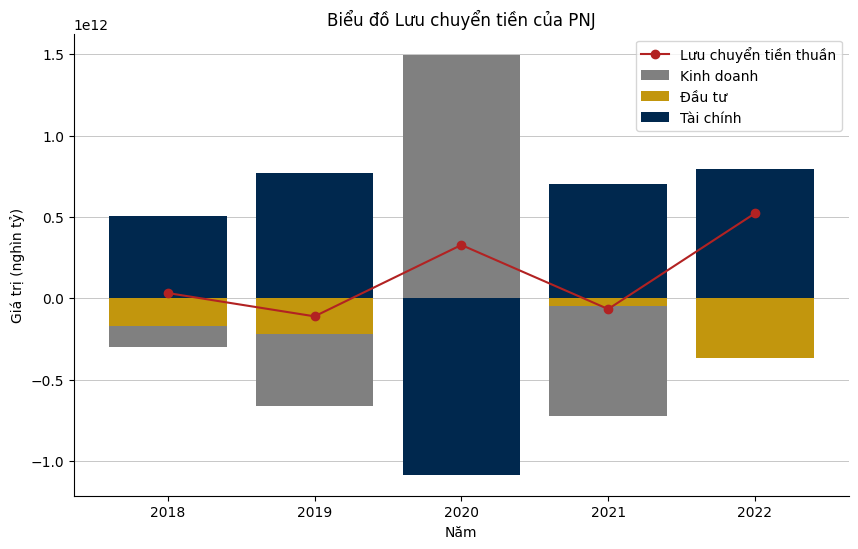

In [34]:
# Tên công ty
company_name = "PNJ"

# Các cột chỉ tiêu Lưu chuyển tiền
LCT_bussiness_column = "LCTT. Lưu chuyển tiền tệ ròng từ các hoạt động sản xuất kinh doanh (TT)"
LCT_finance_column = "LCTT. Lưu chuyển tiền tệ từ hoạt động tài chính (TT)"
LCT_investment_column = "LCTT. Lưu chuyển tiền tệ ròng từ hoạt động đầu tư (TT)"
LCT_net_column = "LCTT. Lưu chuyển tiền thuần trong kỳ (TT)"


# Dữ liệu KQKD và chỉ tiêu tài sản và vốn
pnj_LCT_bussiness = []
pnj_LCT_finance = []
pnj_LCT_investment = []
pnj_LCT_net = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i

    # Lấy giá trị SXKD
    matching_LCT_bussiness_columns = df.filter(like=LCT_bussiness_column)
    LCT_bussiness_column_values = matching_LCT_bussiness_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_LCT_bussiness.append(LCT_bussiness_column_values.values[0])
    # Lấy giá trị HD tài chính
    matching_LCT_finance_columns = df.filter(like=LCT_finance_column)
    LCT_finance_column_values = matching_LCT_finance_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_LCT_finance.append(LCT_finance_column_values.values[0])
    # Lấy giá trị HD đầu tư
    matching_LCT_investment_columns = df.filter(like=LCT_investment_column)
    LCT_investment_column_values = matching_LCT_investment_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_LCT_investment.append(LCT_investment_column_values.values[0])
    # Lấy giá trị thuần
    matching_LCT_net_columns = df.filter(like=LCT_net_column)
    LCT_net_column_values = matching_LCT_net_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_LCT_net.append(LCT_net_column_values.values[0])

# Định nghĩa các năm
years = range(2018, 2018 + len(pnj_LCT_bussiness))

# Tạo đối tượng Axes và đặt kích thước của biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ biểu đồ cột cho chỉ tiêu kinh doanh
ax.bar(years, pnj_LCT_bussiness, label='Kinh doanh', color = 'gray')

# Vẽ biểu đồ cột cho chỉ tiêu đầu tư
ax.bar(years, pnj_LCT_investment, label='Đầu tư', color = '#C2960D')

# Vẽ biểu đồ cột cho chỉ tiêu tài chính
ax.bar(years, pnj_LCT_finance, label='Tài chính', color = '#00284E')

# Vẽ biểu đồ đường cho chỉ tiêu lưu chuyển tiền thuần
ax.plot(years, pnj_LCT_net, color='#B22222', marker='o', label='Lưu chuyển tiền thuần')

# Đặt tiêu đề và nhãn trục
ax.set_title('Biểu đồ Lưu chuyển tiền của PNJ')
ax.set_xlabel('Năm')
ax.set_ylabel('Giá trị (nghìn tỷ)')

# Xóa khung viền phía trên và bên phải của biểu đồ
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ẩn lưới grid phía sau các cột
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='-', linewidth=0.5)

# Thêm chú thích
ax.legend()

# Hiển thị biểu đồ
plt.show()


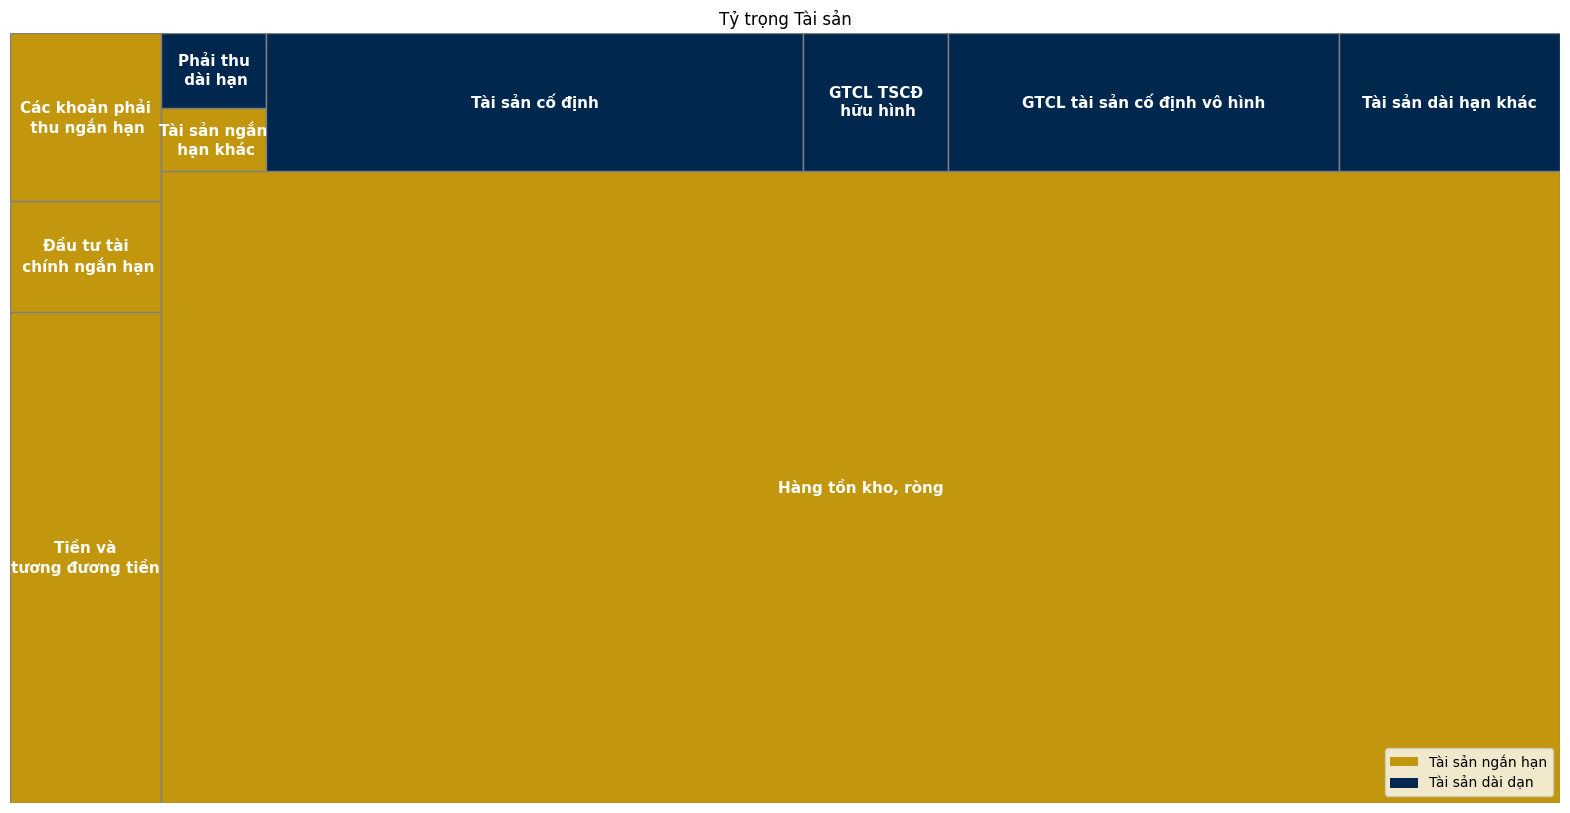

In [35]:
# Các cột chỉ tiêu TSNH
TSNH_money_column = "CĐKT. Tiền và tương đương tiền"
TSNH_finance_column = "CĐKT. Đầu tư tài chính ngắn hạn"
TSNH_phaithu_column = "CĐKT. Các khoản phải thu ngắn hạn"
TSNH_inventory_column = "CĐKT. Hàng tồn kho, ròng"
TSNH_other_current_assets_column = "CĐKT. Tài sản ngắn hạn khác"

# Các cột chỉ tiêu TSDH
TSDH_longterm_receivables_column = "CĐKT. Phải thu dài hạn"
TSDH_fixed_assets_column = "CĐKT. Tài sản cố định"
TSDH_tangible_fixed_assets_column = "CĐKT. GTCL TSCĐ hữu hình"
TSDH_intangible_fixed_assets_column = "CĐKT. GTCL tài sản cố định vô hình"
TSDH_investment_properties_column = "CĐKT. Giá trị ròng tài sản đầu tư"
TSDH_longterm_investments_column = "CĐKT. Đầu tư dài hạn"
TSDH_other_longterm_assets_column = "CĐKT. Tài sản dài hạn khác"


# Dữ liệu TSNH và TSDH
pnj_TSNH_money = []
pnj_TSNH_finance = []
pnj_TSNH_phaithu = []
pnj_TSNH_inventory = []
pnj_TSNH_other_current_assets = []

pnj_TSDH_longterm_receivables = []
pnj_TSDH_fixed_assets = []
pnj_TSDH_tangible_fixed_assets = []
pnj_TSDH_intangible_fixed_assets = []
pnj_TSDH_investment_properties = []
pnj_TSDH_longterm_investments = []
pnj_TSDH_other_longterm_assets = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i

    # Lấy giá trị SXKD
    matching_TSNH_money_columns = df.filter(like=TSNH_money_column)
    TSNH_money_column_values = matching_TSNH_money_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSNH_money.append(TSNH_money_column_values.values[0])
    # Lấy giá trị HD tài chính
    matching_TSNH_finance_columns = df.filter(like=TSNH_finance_column)
    TSNH_finance_column_values = matching_TSNH_finance_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSNH_finance.append(TSNH_finance_column_values.values[0])
    # Lấy giá trị HD đầu tư
    matching_TSNH_phaithu_columns = df.filter(like=TSNH_phaithu_column)
    TSNH_phaithu_column_values = matching_TSNH_phaithu_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSNH_phaithu.append(TSNH_phaithu_column_values.values[0])
    # Lấy giá trị thuần
    matching_TSNH_inventory_columns = df.filter(like=TSNH_inventory_column)
    TSNH_inventory_column_values = matching_TSNH_inventory_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSNH_inventory.append(TSNH_inventory_column_values.values[0])

    # Lấy giá trị SXKD
    matching_TSNH_other_current_assets_columns = df.filter(like=TSNH_other_current_assets_column)
    TSNH_other_current_assets_column_values = matching_TSNH_other_current_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSNH_other_current_assets.append(TSNH_other_current_assets_column_values.values[0])

    #TSDH
    # Lấy giá trị HD tài chính
    matching_TSDH_longterm_receivables_columns = df.filter(like=TSDH_longterm_receivables_column)
    TSDH_longterm_receivables_column_values = matching_TSDH_longterm_receivables_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSDH_longterm_receivables.append(TSDH_longterm_receivables_column_values.values[0])
    # Lấy giá trị HD đầu tư
    matching_TSDH_fixed_assets_columns = df.filter(like=TSDH_fixed_assets_column)
    TSDH_fixed_assets_column_values = matching_TSDH_fixed_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSDH_fixed_assets.append(TSDH_fixed_assets_column_values.values[0])
    # Lấy giá trị thuần
    matching_TSDH_tangible_fixed_assets_columns = df.filter(like=TSDH_tangible_fixed_assets_column)
    TSDH_tangible_fixed_assets_column_values = matching_TSDH_tangible_fixed_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSDH_tangible_fixed_assets.append(TSDH_tangible_fixed_assets_column_values.values[0])

        # Lấy giá trị SXKD
    matching_TSDH_intangible_fixed_assets_columns = df.filter(like=TSDH_intangible_fixed_assets_column)
    TSDH_intangible_fixed_assets_column_values = matching_TSDH_intangible_fixed_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSDH_intangible_fixed_assets.append(TSDH_intangible_fixed_assets_column_values.values[0])
    # Lấy giá trị HD tài chính
    matching_TSDH_investment_properties_columns = df.filter(like=TSDH_investment_properties_column)
    TSDH_investment_properties_column_values = matching_TSDH_investment_properties_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSDH_investment_properties.append(TSDH_investment_properties_column_values.values[0])
    # Lấy giá trị HD đầu tư
    matching_TSDH_longterm_investments_columns = df.filter(like=TSDH_longterm_investments_column)
    TSDH_longterm_investments_column_values = matching_TSDH_longterm_investments_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSDH_longterm_investments.append(TSDH_longterm_investments_column_values.values[0])
    # Lấy giá trị thuần
    matching_TSDH_other_longterm_assets_columns = df.filter(like=TSDH_other_longterm_assets_column)
    TSDH_other_longterm_assets_column_values = matching_TSDH_other_longterm_assets_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_TSDH_other_longterm_assets.append(TSDH_other_longterm_assets_column_values.values[0])

# Danh sách các hạng mục TSNH và TSDH
tsnh_labels = ['Tiền và\ntương đương tiền', 'Đầu tư tài\n chính ngắn hạn', 'Các khoản phải\n thu ngắn hạn', 'Hàng tồn kho, ròng', 'Tài sản ngắn\n hạn khác']
tsdh_labels = ['Phải thu\n dài hạn', 'Tài sản cố định', 'GTCL TSCĐ\n hữu hình', 'GTCL tài sản cố định vô hình', 'Giá trị ròng tài sản đầu tư', 'Đầu tư dài hạn', 'Tài sản dài hạn khác']
# Tỷ trọng của các hạng mục TSNH và TSDH
tsnh_weights = [pnj_TSNH_money[-1], pnj_TSNH_finance[-1], pnj_TSNH_phaithu[-1], pnj_TSNH_inventory[-1], pnj_TSNH_other_current_assets[-1]]
tsdh_weights = [pnj_TSDH_longterm_receivables[-1], pnj_TSDH_fixed_assets[-1], pnj_TSDH_tangible_fixed_assets[-1], pnj_TSDH_intangible_fixed_assets[-1], pnj_TSDH_investment_properties[-1], pnj_TSDH_longterm_investments[-1], pnj_TSDH_other_longterm_assets[-1]]

# Loại bỏ các hạng mục có tỷ trọng bằng 0
tsnh_labels_filtered = [label for label, weight in zip(tsnh_labels, tsnh_weights) if weight != 0]
tsnh_weights_filtered = [weight for weight in tsnh_weights if weight != 0]
tsdh_labels_filtered = [label for label, weight in zip(tsdh_labels, tsdh_weights) if weight != 0]
tsdh_weights_filtered = [weight for weight in tsdh_weights if weight != 0]

# Kết hợp danh sách hạng mục và tỷ trọng đã lọc
labels = tsnh_labels_filtered[:6] + tsdh_labels_filtered[:6]
weights = tsnh_weights_filtered[:6] + tsdh_weights_filtered[:6]

# Đặt màu cho TSNH và TSDH
color_tsnh = '#C2960D'
color_tsdh = '#00284E'
colors = [color_tsnh] * len(tsnh_labels_filtered[:6]) + [color_tsdh] * len(tsdh_labels_filtered[:6])

plt.figure(figsize=(20, 10))
squarify.plot(sizes=weights, label=labels, color=colors, edgecolor='gray', alpha=1,
              text_kwargs={'color': 'white', 'fontsize': 11, 'fontweight': 'bold'})

tsnh_patch = Rectangle((0, 0), 1, 1, fc=color_tsnh)
tsdh_patch = Rectangle((0, 0), 1, 1, fc=color_tsdh)
plt.legend([tsnh_patch, tsdh_patch], ['Tài sản ngắn hạn', 'Tài sản dài dạn'], loc='lower right')

plt.title('Tỷ trọng Tài sản')
plt.axis('off')
plt.show()


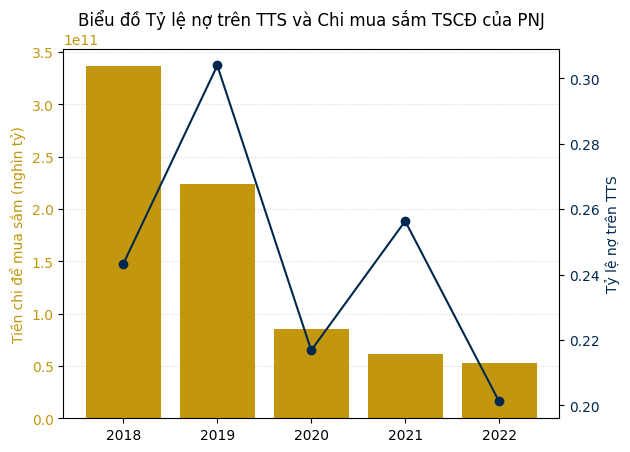

In [36]:
# Tên công ty
company_name = "PNJ"

# Các cột chỉ tiêu Lưu chuyển tiền
LCT_long_assets_expense_column = "LCTT. Tiền chi để mua sắm, xây dựng TSCĐ và các tài sản dài hạn khác (TT)"

pnj_total_debt
pnj_total_assets

# Dữ liệu KQKD và chỉ tiêu tài sản và vốn
pnj_LCT_long_assets_expense = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i

    # Lấy giá trị SXKD
    matching_LCT_long_assets_expense_columns = df.filter(like=LCT_long_assets_expense_column)
    LCT_long_assets_expense_column_values = matching_LCT_long_assets_expense_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_LCT_long_assets_expense.append(LCT_long_assets_expense_column_values.values[0])
pnj_LCT_long_assets_expense = [abs(expense) for expense in pnj_LCT_long_assets_expense]
# Tính Tỷ lệ nợ vay trên tổng vốn
debt_to_total_assets_ratio = [ total_debt / (total_assets) for total_debt, total_assets in zip(total_debt, total_assets)]

# Dữ liệu tỷ lệ nợ vay trên tổng tài sản
years = range(2018, 2018 + len(pnj_total_assets))  # Danh sách các năm

debt_to_total_assets_ratio = [total_debt / total_assets for total_debt, total_assets in zip(pnj_total_debt, pnj_total_assets)]

# Dữ liệu chi mua sắm TSCĐ
LCT_long_assets_expense_years = range(2018, 2018 + len(pnj_LCT_long_assets_expense))
LCT_long_assets_expense = pnj_LCT_long_assets_expense

# Tạo một hình vẽ và trục chính
fig, ax1 = plt.subplots()

# Vẽ biểu đồ cột cho chi mua sắm TSCĐ
ax1.bar(LCT_long_assets_expense_years, LCT_long_assets_expense, color='#C2960D')
ax1.set_ylabel('Tiền chi để mua sắm (nghìn tỷ)', color='#C2960D')
ax1.tick_params(axis='y', labelcolor='#C2960D')

# Tạo một trục thứ hai chia sẻ trục x với trục chính
ax2 = ax1.twinx()

# Vẽ biểu đồ đường cho tỷ lệ nợ vay trên tổng vốn
ax2.plot(years, debt_to_total_assets_ratio, marker='o', color='#00284E')
ax2.set_ylabel('Tỷ lệ nợ trên TTS', color='#00284E')
ax2.tick_params(axis='y', labelcolor='#00284E')

# Xóa khung
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Thêm lưới grid ẩn sau cột
ax1.grid(axis='y', linestyle=':', alpha=0.5)
ax1.set_axisbelow(True)

# Đặt tiêu đề cho biểu đồ
plt.title('Biểu đồ Tỷ lệ nợ trên TTS và Chi mua sắm TSCĐ của PNJ')

# Hiển thị biểu đồ
plt.show()

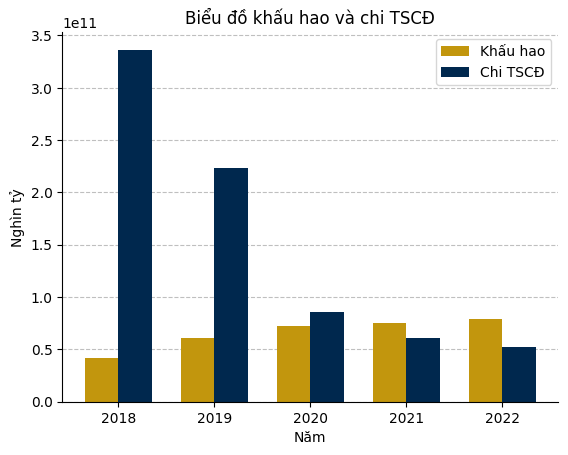

In [37]:
# Dữ liệu khấu hao
pnj_khauhao = []

# Dữ liệu chi mua sắm TSCĐ
pnj_LCT_long_assets_expense = []

# Duyệt qua từng năm trong dfs
for i, df in enumerate(dfs):
    year = 2018 + i

    # Lấy giá trị khấu hao
    matching_khauhao_columns = df.filter(like=khauhao_column)
    khauhao_column_values = matching_khauhao_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_khauhao.append(abs(khauhao_column_values.values[0]))

    # Lấy giá trị chi tiêu TSCĐ
    matching_LCT_long_assets_expense_columns = df.filter(like=LCT_long_assets_expense_column)
    LCT_long_assets_expense_column_values = matching_LCT_long_assets_expense_columns.loc[df["Mã"] == company_name].iloc[:, 0]
    pnj_LCT_long_assets_expense.append(abs(LCT_long_assets_expense_column_values.values[0]))

# Tạo mảng các chỉ số vị trí x
x = np.arange(len(pnj_khauhao))

# Độ rộng của mỗi cột
width = 0.35

# Tạo một hình vẽ và trục
fig, ax = plt.subplots()

# Vẽ biểu đồ cột cho khấu hao
rects1 = ax.bar(x - width/2, pnj_khauhao, width, label='Khấu hao', color = '#C2960D')

# Vẽ biểu đồ cột cho chi tiêu TSCĐ
rects2 = ax.bar(x + width/2, pnj_LCT_long_assets_expense, width, label='Chi TSCĐ', color = '#00284E')

# Đặt tên biểu đồ
ax.set_title('Biểu đồ khấu hao và chi TSCĐ')

# Xóa khung trên và bên phải
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hiển thị lưới grid ẩn sau các cột
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)

# Đặt nhãn trục x và y
ax.set_xlabel('Năm')
ax.set_ylabel('Nghìn tỷ')
ax.set_xticks(x)
ax.set_xticklabels(years)

# Thêm chú thích
ax.legend()

# Hiển thị biểu đồ
plt.show()

Giá cổ phiếu

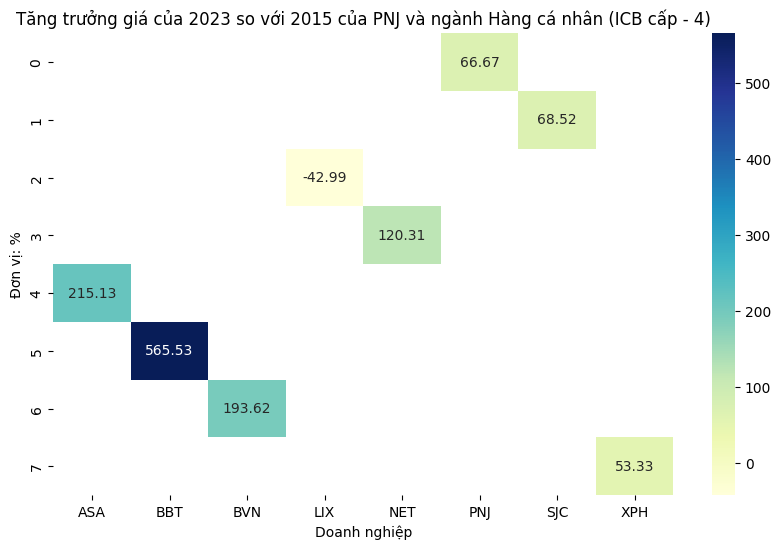

In [38]:
# Giả sử df_price là DataFrame chứa dữ liệu của bạn
dates = [pd.Timestamp('2015-01-01'), pd.Timestamp('2023-11-06')]
companies = ['PNJ', 'SJC', 'LIX', 'NET', 'ASA', 'BBT', 'BVN', 'XPH']
prices = df_price.loc[df_price['Code'].isin(companies), dates]

# Tạo DataFrame từ dữ liệu đã cho
data = {
    '2015-01-01': [7500, 5400, 10700, 21333.44, 18500.11, 11509.68, 4700, 9000],
    '2023-11-06': [12500.0, 9100.0, 6100.0, 47000.0, 58300.0, 76600.0, 13800.0, 13800.0]
}
df = pd.DataFrame(data)

# Tính tăng trưởng giá
growth = (df['2023-11-06'] - df['2015-01-01']) / df['2015-01-01'] * 100

# Tạo DataFrame từ dữ liệu tăng trưởng giá
data = {
    'Companies': companies,
    'Growth': growth
}
df_growth = pd.DataFrame(data)

# Chuyển đổi dữ liệu thành dạng ma trận
heatmap_data = df_growth.pivot(columns='Companies', values='Growth')

# Vẽ heat map
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
plt.title('Tăng trưởng giá của 2023 so với 2015 của PNJ và ngành Hàng cá nhân (ICB cấp - 4)')
plt.xlabel('Doanh nghiệp')
plt.ylabel('Đơn vị: %')
plt.show()


Tính toán chỉ số biểu đồ kỹ thuật

In [39]:
# Tính toán đường trung bình động
price_vol['MA_50'] = price_vol['Giá'].rolling(window=50).mean()
price_vol['MA_200'] = price_vol['Giá'].rolling(window=200).mean()

# Tính toán RSI (Relative Strength Index)
delta = price_vol['Giá'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
rsi = price_vol['RSI'] = 100 - (100 / (1 + rs))

# Tính toán Stochastic Oscillator
stochastic_oscillator = ((price_vol['Giá'] - price_vol['Giá'].rolling(window=14).min()) /
                         (price_vol['Giá'].rolling(window=14).max() - price_vol['Giá'].rolling(window=14).min())) * 100
price_vol['Stochastic_Oscillator'] = stochastic_oscillator

# Tính toán Bollinger Bands
window = 20
price_vol['SMA'] = price_vol['Giá'].rolling(window=window).mean()
price_vol['Bollinger_Upper'] = price_vol['SMA'] + 2 * price_vol['Giá'].rolling(window=window).std()
price_vol['Bollinger_Lower'] = price_vol['SMA'] - 2 * price_vol['Giá'].rolling(window=window).std()

# Tính toán MACD (Moving Average Convergence Divergence)
macd = MACD(price_vol['Giá'], window_slow=26, window_fast=12, window_sign=9)
price_vol['MACD_Line'] = macd.macd()
price_vol['Signal_Line'] = macd.macd_signal()
price_vol['MACD_Histogram'] = price_vol['MACD_Line'] - price_vol['Signal_Line']
price_vol['MACD_Histogram'].fillna(method='ffill', inplace=True)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4292\2681421341.py:30: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



<h1> WEB <h1>

In [42]:
# Tạo ứng dụng Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Phân tích tài chính của PNJ'),
    html.H2(
        children=[
            html.A('Bấm vào đây để mở và tải file PDF', href='https://drive.google.com/file/d/14Gof82PAq3Eo5-P4H4v7DxSvi2xdm2zf/view?usp=sharing',  target="_blank")
        ]
    ),
    html.Label('Chọn chỉ số:'),
    dcc.Dropdown(
        id='indicator-dropdown',
        options=[
            {'label': 'Tỷ lệ tăng trưởng lợi nhuận sau thuế thu nhập doanh nghiệp', 'value': 'LNST'},
            {'label': 'Tỷ lệ tăng trưởng lợi nhuận sau thuế thu nhập doanh nghiệp toàn thị trường (2022)', 'value': 'LNST(2022)'},
            {'label': 'Tỷ lệ tăng trưởng doanh thu thuần', 'value': 'DTT'},
            {'label': 'Tỷ số thanh khoản', 'value': 'TSTK'},
            {'label': 'Tỷ số khả năng sinh lời', 'value': 'KNSL'},
            {'label': 'Tỷ số quản lý tài sản', 'value': 'QLTS'},
            {'label': 'Tỷ số thanh toán lãi vay (TIE)', 'value': 'TIE'},
            {'label': 'Tỷ lệ nợ vay trên tổng vốn', 'value': 'TLNVTTV'},
            {'label': 'Tỷ trọng tài sản', 'value': 'TTTS'},
            {'label': 'Tỷ lệ nợ / TTS và chi mua TSCĐ', 'value': 'TSCD'},
            {'label': 'Khấu hao và chi tài sản cố định', 'value': 'KHTSCD'},
            {'label': 'Tăng trưởng giá cổ phiếu', 'value': 'GCP'},
            {'label': 'Close and Moving Average (MA)', 'value': 'ma'},
            {'label': 'Bollinger Bands', 'value': 'bollinger'},
            {'label': 'MACD', 'value': 'macd'},
            {'label': 'RSI', 'value': 'rsi'},
        ],
        value='LNST'
    ),
    dcc.Graph(id='technical-indicator-graph')
])

# Callback để cập nhật biểu đồ chỉ số dựa trên lựa chọn người dùng
@app.callback(Output('technical-indicator-graph', 'figure'),
              [Input('indicator-dropdown', 'value')])
def update_indicator_chart(selected_indicator):
    if selected_indicator == 'LNST':
        # Tạo figure cho biểu đồ
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=[2019, 2020, 2021, 2022],
            y=pnj_growth_rates,
            mode='markers',
            marker=dict(color='#00284E'),
            name='Tăng trưởng LSNT PNJ'
        ))
        fig.add_trace(go.Scatter(
            x=smooth_years,
            y=pnj_smooth_growth_rates,
            mode='lines',
            line=dict(color='#00284E'),
            showlegend=False
        ))

        fig.add_trace(go.Scatter(
            x=[2019, 2020, 2021, 2022],
            y=growth_rates,
            mode='markers',
            marker=dict(color='#C2960D'),
            name='Tăng trưởng LSNT Ngành hàng cá nhân (ICB - cấp 3)'
        ))
        fig.add_trace(go.Scatter(
            x=smooth_years,
            y=smooth_growth_rates,
            mode='lines',
            line=dict(color='#C2960D'),
            showlegend=False
        ))

        fig.update_layout(
            xaxis={'title': 'Năm'},
            yaxis={'title': 'Tỷ lệ tăng trưởng (%)'},
            hovermode='closest',
            plot_bgcolor='white',
            margin=dict(l=50, r=50, t=50, b=200),
            height=600,
        )
            # Thêm chú thích phân tích
        analysis_text1 = 'Biểu đồ trên cho thấy sự biến động về lợi nhuận sau thuế của PNJ và trung bình ngành. Nửa đầu năm 2019 chứng kiến sự sụt giảm'
        analysis_text2 = 'trong tỷ lệ tăng trưởng lợi nhuận sau thuế của PNJ và trung bình ngành.  Điều này có thể là do sự ảnh hưởng tiêu cực của đại dịch Covid-19 lên Việt Nam'
        analysis_text3 = 'Sau đó, chỉ số của toàn ngành và PNJ đều có sự khởi sắc. Tuy nhiên, tỷ lệ lợi nhuận sau thuế của trung bình ngành đã giảm hơn 30% vào năm 2022,'
        analysis_text4 = 'điều này cho thấy thị trường có thể gặp những khó khăn. Trong khi đó, chỉ số của PNJ tăng vọt lên hơn 75%. Thành quả này của PNJ '
        analysis_text5 = 'cũng một phần đến từ việc đội ngũ lãnh đạo đã liên tục làm mới, tăng tốc tái tạo và ứng biến trong suốt thời gian qua với các chương trình'
        analysis_text6 = 'khuyến mãi hấp dẫn, sự thay đổi cơ cấu bán hàng và các yếu tố vĩ mô. Chính điều này cho thấy PNJ có tiềm năng tiếp tục tăng trưởng trong tương lai.'

        annotation_text = f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}<br>{analysis_text4}<br>{analysis_text5}<br>{analysis_text6}</span>'
        
        fig.add_annotation(
        xref='paper',
        yref='paper',
        x=1.3,
        y=-0.2,
        xanchor='right',
        yanchor='top',
        text= annotation_text,
        showarrow=False,
        font=dict(size=12)
    )
        return fig
    elif selected_indicator == 'LNST(2022)':
            # Tạo figure cho biểu đồ
        fig2 = go.Figure()
        fig2.add_trace(go.Bar(
            x=industries,
            y=rates_2022,
            marker=dict(
                color=['#C2960D' if rate < 0 else '#00284E' for rate in rates_2022]
        ),
            text=[f'{rate:.1f}%' for rate in rates_2022],
            textposition='auto',
            textfont=dict(
                color=['white' if abs(rate) < 5 else 'black' for rate in rates_2022]
        )
    ))

        fig2.update_layout(
            xaxis={'title': 'Ngành'},
            yaxis={'title': 'Tỷ lệ tăng trưởng YoY (%)'},
            hovermode='closest',
            plot_bgcolor='white',
            margin=dict(l=50, r=50, t=50, b=400),
            height=600,
    )

    # Thêm chú thích phân tích
        analysis_text1 = 'Trong năm 2022, nhìn chung toàn thị trường đều có sự sụt giảm trong tỷ lệ tăng trưởng lợi nhuận sau thuế,'
        analysis_text2 = 'đặc biệt là ngành Y tế với mức sụt giảm nghiêm trọng. Trong tình hình chung như vậy thì'
        analysis_text3 = 'ngành Bất động sản và Viễn thông là hai ngành có mức tăng trưởng lợi nhuận sau thuế cao nhất.'
        analysis_text4 = 'Điều đặc biệt là trong khi đa phần thị trường và trung bình ngành Hàng cá nhân & Gia dụng giảm nhẹ thì'
        analysis_text5 = 'PNJ - doanh nghiệp thuộc ngành này - lại cho thấy mức tăng trưởng đáng kể lợi nhuận sau thuế. Điều này là do'
        analysis_text6 = 'PNJ đã có chiến lược marketing phù hợp, năng lực bán lẻ phát triển và người dân có nhu cầu mua tài sản để tích trữ hậu đại dịch.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}<br>{analysis_text4}<br>{analysis_text5}<br>{analysis_text6}</span>'
        fig2.add_annotation(
            xref='paper',
            yref='paper',
            x=0.8,
            y=-1,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=12)
    )
        return fig2
    elif selected_indicator == 'TSTK':
        years = [2018, 2019, 2020, 2021, 2022]
# Tạo biểu đồ mới
        fig3 = go.Figure()

# Vẽ biểu đồ chỉ số thanh khoản hiện hành và chỉ số thanh khoản nhanh của PNJ
        fig3.add_trace(go.Scatter(x=years, y=current_ratio, mode='lines', name='Tỷ số thanh khoản hiện hành (PNJ)', line=dict(color='#C2960D')))
        fig3.add_trace(go.Scatter(x=years, y=quick_ratio, mode='lines', name='Tỷ số thanh khoản nhanh (PNJ)', line=dict(color='#00284E')))

# Vẽ biểu đồ chỉ số thanh khoản hiện hành và chỉ số thanh khoản nhanh của hàng tiêu dùng
        fig3.add_trace(go.Scatter(x=years, y=current_ratio2, mode='lines', name='Tỷ số thanh khoản hiện hành (Hàng cá nhân)', line=dict(color='gray')))
        fig3.add_trace(go.Scatter(x=years, y=quick_ratio2, mode='lines', name='Tỷ số thanh khoản nhanh (Hàng cá nhân)', line=dict(color='#800080')))

        fig3.update_layout(
        xaxis={'title': 'Năm'},
        yaxis={'title': 'Tỷ số thanh khoản'},
        hovermode='closest',
        plot_bgcolor='white',
        margin=dict(l=40, r=40, t=50, b=210),
        height=400,
        legend=dict(x=1.2, y=1)
    )
    # Thêm chú thích phân tích
        analysis_text1 = 'Trong 5 năm kể từ năm 2018 đến năm 2022, tỷ số thanh khoản và tỷ số thanh khoản nhanh của PNJ biến động không đều,'
        analysis_text2 = 'nhưng tỷ số thanh khoản hiện vẫn dao động quanh mức trung bình. Trong năm 2021, tỷ số thanh khoản giảm so với năm 2020 và 2022.'
        analysis_text3 = 'Điều này cho thấy, trong năm 2021, PNJ gặp khó khăn tài chính và công ty sẽ chi trả cho các hóa đơn cần thanh toán chậm trễ hơn. Năm 2022, tỷ số'
        analysis_text4 = 'thanh khoản hiện hành của PNJ vượt mốc 2.45, điều này cho thấy rủi ro công ty đang nắm giữ quá nhiều hàng tồn kho và khoản thu sắp trở thành nợ khó đòi'
        analysis_text5 = 'hoặc công ty đang nắm quá nhiều tiền, khoản phải thu và hàng tồn kho so với doanh thu của mình, nó cũng thể hiện khả năng sinh lời thấp.' 
        analysis_text6 = 'Công ty nên điều chỉnh chỉ số thanh khoản hiện hành về trong khoảng 1 đến 2 để ổn định hơn. Trừ năm 2019 và 2021 với nhiều biến động, tỷ số thanh khoản hiện hành'
        analysis_text7 = 'PNJ tương đối cao hơn trung bình ngành. Tỷ số thanh khoản nhanh của PNJ thấp hơn nhiều so với trung bình ngành cho thấy khả năng'
        analysis_text9 = 'công ty không tính đến hàng tồn kho và các tài sản ngắn hạn để thanh toán cho các khoản nợ ngắn hạn.  Công ty sẽ cần phải xem xét'
        analysis_text10 = 'đến khả năng có thể sẽ phải bán hàng tồn kho để có dòng tiền chi trả cho các khoản nợ đến hạn.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}<br>{analysis_text4}<br>{analysis_text5}<br>{analysis_text6}<br>{analysis_text7}<br>{analysis_text9}<br>{analysis_text10}</span>'
        fig3.add_annotation(
            xref='paper',
            yref='paper',
            x=1.5,
            y=-0.3,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=12)
    )
        return fig3
    elif selected_indicator == 'DTT':
        years = [2018, 2019, 2020, 2021, 2022]
        # Tạo đối tượng biểu đồ
        fig4 = go.Figure()
        fig4.add_trace(go.Scatter(
            x=[2019, 2020, 2021, 2022],
            y=pnj_growth_rates3,
            mode='markers',
            marker=dict(color='#00284E'),
            name='Tăng trưởng Doanh thu thuần PNJ'
        ))
        fig4.add_trace(go.Scatter(
            x=smooth_years3,
            y=pnj_smooth_growth_rates3,
            mode='lines',
            line=dict(color='#00284E'),
            showlegend=False
        ))

        fig4.add_trace(go.Scatter(
            x=[2019, 2020, 2021, 2022],
            y=growth_rates3,
            mode='markers',
            marker=dict(color='#C2960D'),
            name='Tăng trưởng Doanh thu thuần Ngành hàng cá nhân (ICB - cấp 3)'
        ))
        fig4.add_trace(go.Scatter(
            x=smooth_years3,
            y=smooth_growth_rates3,
            mode='lines',
            line=dict(color='#C2960D'),
            showlegend=False
        ))

# Cấu hình biểu đồ
        fig4.update_layout(
    xaxis={'title': 'Năm'},
    yaxis={'title': 'Tỷ lệ tăng trưởng (%)'},
    hovermode='closest',
    plot_bgcolor='white',
    legend=dict(x=0, y=1),
    height=600,
    margin=dict(l=50, r=50, t=50, b=250),
)
        #Thêm chú thích
        analysis_text1 = 'Đường cong của PNJ có độ dốc tương đối ổn định, cho thấy doanh thu thuần của PNJ đang có xu hướng tăng trưởng bền vững.'
        analysis_text2 = 'Doanh thu thuần của ngành cũng chứng kiến sự phát triển tương tự với tốc độ thấp hơn PNJ, tuy nhiên'
        analysis_text3 = 'đường cong này có xu hướng giảm nhẹ vào cuối 2022 - đầu 2023, cho thấy thị trường có thể đang gặp khó khăn.'
        analysis_text4 = 'Bên cạnh đó, tỷ lệ tăng trưởng doanh thu thuần của PNJ đang cao hơn so với trung bình ngành trong suốt thời kỳ, cho thấy PNJ'
        analysis_text5 = 'đang có lợi thế cạnh tranh so với các đối thủ trong mảng Hàng cá nhân. Đây là một dấu hiệu tốt, cho thấy PNJ có rất nhiều tiềm năng.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}<br>{analysis_text4}<br>{analysis_text5}</span>'
        fig4.add_annotation(
            xref='paper',
            yref='paper',
            x=0.8,
            y=-0.3,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=12)
    )
        return fig4
    elif selected_indicator == 'KNSL':
        years = [2018, 2019, 2020, 2021, 2022]
        data = [operating_profit_margin, gross_profit_margin, net_profit_margin, roa, roe, bep]
        labels = ["Biên lợi nhuận hoạt động", "Biên lợi nhuận gộp", "Biên lợi nhuận ròng", "ROA", "ROE", "BEP"]
        color_palette = ['#FFA500', '#008080', '#800080', '#C2960D', '#00284E', 'gray']

        fig5 = sp.make_subplots(rows=2, cols=1)

        for i in range(len(years)):
            bar = go.Bar(
                x=labels,
                y=[data[j][i] for j in range(len(data))],
                name=str(years[i]),
                marker=dict(color=color_palette[i])
        )
            fig5.add_trace(bar, row=1, col=1)

        fig5.update_layout(
            xaxis={'title': 'Chỉ số'},
            yaxis={'title': 'Giá trị (%)'},
            title='Nhóm tỷ số khả năng sinh lời của PNJ',
            barmode='group',
            legend=dict(title='Năm'),
            height=600,
            margin=dict(l=50, r=50, t=50, b=80),
    )

    #Ngành Fig6
        years = [2018, 2019, 2020, 2021, 2022]
        data = [operating_profit_margin2, gross_profit_margin2, net_profit_margin2, roa2, roe2, bep2]
        labels = ["Biên lợi nhuận hoạt động", "Biên lợi nhuận gộp", "Biên lợi nhuận ròng", "ROA", "ROE", "BEP"]
        color_palette = ['#FFA500', '#008080', '#800080', '#C2960D', '#00284E', 'gray']

        for i in range(len(years)):
            bar = go.Bar(
                x=labels,
                y=[data[j][i] for j in range(len(data))],
                name=str(years[i]),
                marker=dict(color=color_palette[i])
        )
            fig5.add_trace(bar, row=2, col=1)

        fig5.update_layout(
            xaxis={'title': 'Chỉ số'},
            yaxis={'title': 'Giá trị (%)'},
            title='Nhóm tỷ số khả năng sinh lời của PNJ (biểu đồ ở trên) và ngành Hàng cá nhân (ICB cấp 3 - biểu đồ ở dưới)',
            barmode='group',
            legend=dict(title='Năm'),
            height=800,
            margin=dict(l=50, r=50, t=50, b=250),
    )
    #Thêm chú thích
        analysis_text1 = '- Từ năm 2018 đến năm 2022, biên lợi nhuận hoạt động của PNJ đã giảm còn khoảng hơn 6.4%, điều này cho thấy lợi nhuận thu được từ hoạt động kinh doanh có sự sụt giảm.'
        analysis_text2 = 'Con số này thấp hơn một chút so với trung bình ngành hàng cá nhân (5.3%). - Biên lợi nhuận gộp cũng có sự sụt giảm từ 2018 đến 2021 cho thấy dấu hiệu về việc hoạt động kinh doanh khó có lãi,'
        analysis_text3 = 'tuy nhiên chỉ số này đã được cải thiện vào năm 2022. Biên lợi nhuận gộp của PNJ cũng cao hơn một chút so với trung bình ngành. → Nhìn chung, biên lợi nhuận của công ty qua các năm có'
        analysis_text4 = 'sự giảm nhẹ và dần hồi phục, tuy nhiên cũng không có quá nhiều sự chênh lệch so với trung bình ngành.  Điều này cho thấy PNJ đã quản lý, kiểm soát chi phí tương đối tốt và có khả năng'
        analysis_text5 = 'cạnh tranh với các doanh nghiệp cùng ngành và trên thị trường. - ROA (tỷ lệ lợi nhuận trên tổng tài sản) có sự tăng giảm không đều, giảm từ 15% năm 2019 xuống còn khoảng 9,5% vào năm 2021'
        analysis_text6 = 'và tăng lên khoảng 13,6% vào năm 2022. Trong năm gần nhất, ROA của PNJ cao hơn trung bình ngành, điều này cho thấy công ty sử dụng tài sản một cách hiệu quả. '
        analysis_text7 = '- ROE (tỷ lệ lợi nhuận trên vốn chủ sở hữu)  cũng có sự tăng giảm không đều và đạt khoảng 21.5% vào năm 2022. Con số này cũng cao hơn so với trung bình ngành, điều này cho thấy khả năng sinh lời '
        analysis_text8= 'và hiệu quả sử dụng vốn của công ty có hiệu quả, doanh nghiệp đang tạo ra doanh thu tốt từ tài sản đang có thì khả năng doanh nghiệp sẽ có khả năng thanh toán và đảo vòng vốn ổn định hơn. → ROA'
        analysis_text9 = ' và ROE của công ty đều có sự sụt giảm vào năm 2021, nguyên nhân có thể là do ảnh hưởng của Covid-19. Tuy nhiên, cả hai chỉ số này đều gia tăng vào 2022 và đạt mức cao hơn trung bình ngành,'
        analysis_text10 = 'cho thấy công ty đang có chính sách quản lý vốn và tài sản hợp lý. Công ty cần làm cho hai tỷ số này tăng trưởng một cách ổn định trong tương lai. - BEP (tỷ số sức sinh lời cơ bản) của PNJ'
        analysis_text11 = 'có xu hướng giảm từ 2019 đến 2021 và tăng lên vào 2022. Con số này cũng đạt mức cao hơn trung bình ngành. Chỉ số này cho thấy PNJ đang cố gắng đạt hiệu quả tốt hơn trong khả năng'
        analysis_text12 = 'sử dụng tài sản để tạo ra lợi nhuận hoạt động của công ty.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}<br>{analysis_text4}<br>{analysis_text5}<br>{analysis_text6}<br>{analysis_text7}<br>{analysis_text8}<br>{analysis_text9}<br>{analysis_text10}<br>{analysis_text11}<br>{analysis_text12}</span>'

        fig5.add_annotation(
            xref='paper',
            yref='paper',
            x=1.1,
            y=-0.1,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )
        return fig5
    elif selected_indicator == 'QLTS':
        # Define the data
        years = [2018, 2019, 2020, 2021, 2022]
        index_labels = ['Vòng quay hàng tồn kho', 'Vòng quay TSCĐ', 'Vòng quay TTS']
        data_pnj = [pnj_inventory_turnover_ratio, pnj_fixed_assets_turnover_ratio, pnj_total_assets_turnover_ratio]
        data_icb = [inventory_turnover_ratio, fixed_assets_turnover_ratio, total_assets_turnover_ratio]
        color_palette = ['gray', '#C2960D', '#00284E']

# Create subplots
        fig6 = sp.make_subplots(rows=1, cols=2, subplot_titles=['Tỷ số quản lý tài sản của PNJ', 'Tỷ số quản lý tài sản của ngành hàng cá nhân (ICB - cấp 3)'])

# Add PNJ subplot
        for i in range(len(data_pnj)):
            fig6.add_trace(
            go.Bar(x=years, y=data_pnj[i], name=index_labels[i], marker=dict(color=color_palette[i])),
            row=1, col=1
    )

# Add industry subplot
        for i in range(len(data_icb)):
            fig6.add_trace(
            go.Bar(x=years, y=data_icb[i], name=index_labels[i], marker=dict(color=color_palette[i])),
            row=1, col=2
    )
# Update layout
        fig6.update_layout(
            xaxis=dict(title='Năm'),
            yaxis=dict(title='Tỷ số'),
            barmode='group',
            legend=dict(title='Chỉ số'),
            height=600,
            margin=dict(l=50, r=50, t=50, b=200),
)
        analysis_text1 = '- Tỷ số vòng quay tài sản cố định tăng dần và đạt mức cao nhất vào năm 2022, điều này cho thấy PNJ sử dụng tài sản cố định một cách hiệu quả trong việc tạo ra doanh thu.'
        analysis_text2 = '- Tỷ số vòng quay tổng tài sản biến động không đều, tuy nhiên chỉ dao động ở mức độ nhẹ và đạt mốc cao nhất vào 2022. Điều này cho thấy sự đổi mới, tái cơ cấu công ty'
        analysis_text3 = 'và sự phục hồi của ngành hàng sau dịch Covid-19. - Tỷ số vòng quay hàng tồn kho cũng biến động không đều và đạt ngưỡng cao nhất vào năm 2022. Đây chính là sự nỗ lực của'
        analysis_text4 = 'cả tập đoàn khi tái cơ cấu hàng tồn kho. Đồng thời, tỷ số hàng tồn kho tăng vào năm 2022 cũng chính là dấu hiệu cho thấy công ty có thể có doanh thu cao hơn hoặc đang'
        analysis_text5 = 'không đủ lượng hàng tồn kho cần thiết cho doanh nghiệp. - So với trung bình ngành, có thể thấy rõ ràng là vòng quay hàng tồn kho của PNJ thấp hơn so với trung bình ngành.'
        analysis_text6 = 'Điều này cho thấy PNJ nên xem xét lại kỹ lưỡng cơ cấu hàng tồn kho của mình. - PNJ có vòng quay tài sản cố định cao gấp nhiều lần so với trung bình ngành, điều này cho thấy'
        analysis_text7 = 'công ty đang sử dụng tài sản cố định hiệu quả trong việc tạo ra doanh thu. - Vòng quay tổng tài sản của PNJ cao hơn trung bình ngành, điều này cho thấy công ty đang hoạt động'
        analysis_text8= 'hiệu quả và tạo ra nhiều doanh thu trên một đồng tài sản.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}<br>{analysis_text4}<br>{analysis_text5}<br>{analysis_text6}<br>{analysis_text7}<br>{analysis_text8}</span>'

        fig6.add_annotation(
            xref='paper',
            yref='paper',
            x=1.1,
            y=-0.15,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )
        return fig6
    elif selected_indicator == 'TIE':
        # Tạo list chỉ số để hiển thị trên trục hoành
        index_labels = ['Ngành Hàng cá nhân', 'PNJ']

# Tạo list dữ liệu cột cho TIE của từng chỉ số
        data = [tie, pnj_tie]

# Lấy giá trị tuyệt đối cho các giá trị trong data
        data = [np.abs(d) for d in data]

        years = [2018, 2019, 2020, 2021, 2022]

        fig7 = go.Figure()

# Tạo các cột dữ liệu
        color_palette = ['#C2960D', '#00284E']
        for i, d in enumerate(data):
            fig7.add_trace(go.Bar(
            x=years,
            y=d,
            name=index_labels[i],
            marker=dict(color=color_palette[i])
    ))

# Cấu hình giao diện đồ thị
        fig7.update_layout(
        xaxis=dict(title='Năm'),
        yaxis=dict(title='Tỷ số'),
        title='Biểu đồ Tỷ số thanh toán lãi vay (TIE) của PNJ và Ngành Hàng cá nhân (ICB - cấp 3)',
        barmode='group',
        legend=dict(title='Chỉ số'),
        height=600,
        margin=dict(l=50, r=50, t=50, b=180),
)
        analysis_text1 = '- TIE (hệ số khả năng trả nợ) của PNJ có sự biến động giảm mạnh vào 2019 và 2020 nhưng có sự phục hồi'
        analysis_text2 = 'vào năm 2021 và đạt mức cao nhất - 25,75 lần vào năm 2022. Chỉ số này cũng cao hơn nhiều lần so với trung bình ngành,'
        analysis_text3 = 'cho thấy PNJ có đủ thu nhập để thanh toán khoản vay của mình và PNJ đang có tình hình tài chính lành mạnh.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}</span>'

        fig7.add_annotation(
            xref='paper',
            yref='paper',
            x=0.9,
            y=-0.15,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )
        return fig7
    elif selected_indicator == 'TLNVTTV':
        # Tạo list chỉ số để hiển thị trên trục hoành
        index_labels = ['Ngành Hàng cá nhân', 'PNJ']

# Tạo list dữ liệu cột cho TIE của từng chỉ số
        data = [debt_to_equity_ratio, pnj_debt_to_equity_ratio]

# Lấy giá trị tuyệt đối cho các giá trị trong data
        data = [np.abs(d) for d in data]

        years = [2018, 2019, 2020, 2021, 2022]

        fig8 = go.Figure()

# Tạo các cột dữ liệu
        color_palette = ['#C2960D', '#00284E']
        for i, d in enumerate(data):
            fig8.add_trace(go.Bar(
            x=years,
            y=d,
            name=index_labels[i],
            marker=dict(color=color_palette[i])
    ))

# Cấu hình giao diện đồ thị
        fig8.update_layout(
        xaxis=dict(title='Năm'),
        yaxis=dict(title='Tỷ số'),
        title='Biểu đồ Tỷ số nợ trên tổng vốn của PNJ và Ngành Hàng cá nhân (ICB - cấp 3)',
        barmode='group',
        legend=dict(title='Chỉ số'),
        height=600,
        margin=dict(l=50, r=50, t=50, b=180),
)
        analysis_text1 = '- Tỷ số nợ trên vốn của PNJ có sự biến đổi không đều nhưng đều ở mức dưới 1 và thấp sơn so với trung bình ngành một chút. Điều đó cho thấy'
        analysis_text2 = 'tài khoản hiện có của doanh nghiệp do nguồn vốn chủ sở hữu tài trợ và tỷ lệ nợ thấp hơn phần vốn chủ sở hữu, PNJ đang quản lý rủi ro từ'
        analysis_text3 = 'những khoản nợ khá tốt. Bên cạnh đó, tỷ số năm 2022 thấp hơn các năm trước cho thấy năng lực tài chính của PNJ đang ngày càng mạnh.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}</span>'

        fig8.add_annotation(
            xref='paper',
            yref='paper',
            x=0.9,
            y=-0.15,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )
        return fig8
    elif selected_indicator == 'TTTS':
        # Kết hợp danh sách hạng mục và tỷ trọng đã lọc
        labels = tsnh_labels_filtered[:6] + tsdh_labels_filtered[:6]
        sizes = tsnh_weights_filtered[:6] + tsdh_weights_filtered[:6]

# Đặt màu cho TSNH và TSDH
        color_tsnh = '#C2960D'
        color_tsdh = '#00284E'
        colors = [color_tsnh] * len(tsnh_labels_filtered[:6]) + [color_tsdh] * len(tsdh_labels_filtered[:6])

# Tạo DataFrame từ danh sách hạng mục và tỷ trọng
        df = pd.DataFrame({'labels': labels, 'sizes': sizes, 'colors': colors})

# Khởi tạo đối tượng Fig
        fig10 = go.Figure(go.Treemap(
            labels=df['labels'],
            parents=[''] * len(df),  # Tất cả các nút là root node
            values=df['sizes'],
            marker=dict(
                colors=df['colors'],
                line=dict(width=0.5, color='gray')
    ),
            textposition='middle center',
            textfont=dict(
                color='white',
                size=11,
    )
))

# Tạo legend
        tsnh_trace = go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(color=color_tsnh),
            legendgroup='Tài sản ngắn hạn',
            name='Tài sản ngắn hạn'
)
        tsdh_trace = go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(color=color_tsdh),
            legendgroup='Tài sản dài hạn',
            name='Tài sản dài hạn'
)
        fig10.add_trace(tsnh_trace)
        fig10.add_trace(tsdh_trace)

# Cấu hình layout
        fig10.update_layout(
            title='Tỷ trọng Tài sản',
            showlegend=True,
            margin=dict(l=50, r=50, t=50, b=180),
            legend=dict(
                itemsizing='constant'
    )
)
        analysis_text1 = 'Khoản mục chiếm tỷ trọng lớn nhất trong danh mục tài sản của doanh nghiệp là Hàng tồn kho. Một điểm đáng chú ý nữa là PNJ có xu hướng nắm giữ nhiều tài sản ngắn hạn'
        analysis_text2 = 'hơn so với tài sản dài hạn trong tổng tài sản, lý do chính có thể là do tài sản ngắn hạn có sự linh hoạt cao hơn trong các vấn đề tài chính và thanh toán.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}</span>'

        fig10.add_annotation(
            xref='paper',
            yref='paper',
            x=1,
            y=-0.15,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )
        return fig10
    elif selected_indicator == 'TSCD':
        # Tạo biểu đồ
        fig11 = go.Figure()

# Vẽ biểu đồ cột cho chi mua sắm TSCĐ
        fig11.add_trace(go.Bar(
            x=[2018, 2019, 2020, 2021, 2022],
            y=[abs(expense) for expense in pnj_LCT_long_assets_expense],
            name='Chi mua sắm TSCĐ',
            marker_color='#C2960D'
))

# Vẽ biểu đồ đường cho tỷ lệ nợ vay trên tổng vốn
        fig11.add_trace(go.Scatter(
            x=[2018, 2019, 2020, 2021, 2022],
            y=debt_to_total_assets_ratio,
            name='Tỷ lệ nợ trên TTS',
            mode='lines+markers',
            marker_color='#00284E',
            yaxis='y2'  # Chỉ định sử dụng trục y phụ
))

# Cấu hình biểu đồ
        fig11.update_layout(
            title='Biểu đồ Tỷ lệ nợ / TTS và Chi mua sắm TSCĐ của PNJ',
            margin=dict(b=130),
            xaxis_title='Năm',
            yaxis=dict(
                title='Tiền chi để mua sắm (nghìn tỷ)',
                side='left',
                color='#C2960D'
    ),
            yaxis2=dict(
                title='Tỷ lệ nợ trên TTS',
                side='right',
                overlaying='y',
                color='#00284E'
    ),
            legend=dict(
                x=0.5,
                y=1.1,
                orientation='h'
    )
)
        analysis_text1 = 'Tỷ lệ Nợ/Tổng tài sản của PNJ đang có xu hướng giảm ở kỳ vừa qua. Điều này cho thấy PNJ đang có sự ổn định và ít gặp khó khăn hơn trong việc trả nợ'
        analysis_text2 = 'doanh nghiệp đảm bảo được các khoản nợ dài hạn bằng mức tài sản cao. Chỉ số này hiện đang nằm ở mức an toàn so với mặt bằng chung của ngành.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}</span>'

        fig11.add_annotation(
            xref='paper',
            yref='paper',
            x=1,
            y=-0.15,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )
        return fig11
    elif selected_indicator == 'KHTSCD':
        years = [2018, 2019, 2020, 2021, 2022]

# Tạo biểu đồ
        fig12 = go.Figure()

# Vẽ biểu đồ cột cho khấu hao
        fig12.add_trace(go.Bar(
            x=years,
            y=pnj_khauhao,
            name='Khấu hao',
            marker_color='#C2960D'
))

# Vẽ biểu đồ cột cho chi tiêu TSCĐ
        fig12.add_trace(go.Bar(
            x=years,
            y=pnj_LCT_long_assets_expense,
            name='Chi TSCĐ',
            marker_color='#00284E'
))

# Cấu hình biểu đồ
        fig12.update_layout(
            title='Biểu đồ khấu hao và chi TSCĐ của PNJ',
            margin=dict(b=130),
            xaxis_title='Năm',
            yaxis_title='Nghìn tỷ',
            legend=dict(
                x=0.8,
                y=1.1,
                orientation='h'
    )
)
        analysis_text1 = 'Trong hai năm gần nhất, doanh nghiệp có chi đầu tư cho các khoản tài sản cố định. Tuy nhiên, khi so sánh với mức khấu hao'
        analysis_text2 = 'trong cùng khoảng thời gian này, các khoản chi đầu tư đa phần thấp hơn so với khấu hao đã được trích. Điều này cho thấy PNJ có thể đã'
        analysis_text3 = 'chuyển sang mục tiêu tối ưu hóa chi phí và quy mô hoạt động sau khi đã đầu tư nhiều vào tài sản cố định trong những năm 2018 và 2019.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}</span>'

        fig12.add_annotation(
            xref='paper',
            yref='paper',
            x=0.9,
            y=-0.15,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )
        return fig12
    elif selected_indicator == 'GCP':
        data = {
    'Companies': ['PNJ', 'BBT', 'LIX', 'NET', 'ASA', 'SJC', 'BVN', 'XPH'],
    '2015-01-01': [7500, 11509.68, 10700, 21333.44, 18500.11, 5400, 4700, 9000],
    '2023-11-06': [12500.0, 76600.0, 6100.0, 47000.0, 58300.0, 9100.0, 13800.0, 13800.0]

}
        df = pd.DataFrame(data)

# Tính tăng trưởng giá
        df['Growth'] = (df['2023-11-06'] - df['2015-01-01']) / df['2015-01-01'] * 100
        # Tạo biểu đồ Heatmap
        fig13 = go.Figure(data=go.Heatmap(
            z=[df['Growth']],
            x=df['Companies'],
            y=['Tăng trưởng giá'],
            colorscale='YlGnBu',
            colorbar=dict(title='Tăng trưởng (%)'),
))

# Cấu hình biểu đồ
        fig13.update_layout(
            title='Tăng trưởng giá của 2023 so với 2015 của PNJ và ngành Hàng cá nhân (ICB cấp - 4)',
            margin=dict(b=130),
            xaxis=dict(title='Doanh nghiệp'),
            yaxis=dict(title='Đơn vị: %'),
)
        
        analysis_text1 = 'Nhìn chung, giá cổ phiếu của ngành Hàng cá nhân (ICB cấp 4) đã có sự tăng trưởng mạnh mẽ trong giai đoạn 2015 - 2023. Heatmap này cho thấy'
        analysis_text2 = 'tỷ lệ tăng trưởng giá nằm ở mức trung bình của PNJ so với các công ty khác trong ngành Hàng tiêu dùng (ICB cấp - 4) từ năm 2015 đến năm 2023'
        analysis_text3 = 'Điều này cho thấy giá cổ phiếu của PNJ đã tăng gần gấp rưỡi trong giai đoạn này. So với SJC - đối thủ cạnh tranh trực tiếp của PNJ - có thể thấy'
        analysis_text4 = 'tỷ lệ tăng trưởng giá của 2 công ty này là gần như nhau. Sự cạnh tranh giữa 2 công ty hàng đầu trong lĩnh vực trang sức đã giúp họ phát triển để'
        analysis_text5 = ' thu hút khách hàng và tăng giá trị cho cổ đông. Điều này chứng tỏ cổ phiếu của PNJ tuy không quá mạnh, nhưng vẫn đáng để đầu tư dài hạn trong tương lai.'
        annotation_text =  f'<span>{analysis_text1}<br>{analysis_text2}<br>{analysis_text3}<br>{analysis_text4}<br>{analysis_text5}</span>'

        fig13.add_annotation(
            xref='paper',
            yref='paper',
            x=1.05,
            y=-0.12,
            xanchor='right',
            yanchor='top',
            text=annotation_text,
            showarrow=False,
            font=dict(size=11.5)
        )

        return fig13
    elif selected_indicator == 'ma':
            # Tạo biểu đồ
        fig14 = go.Figure()
        fig14.add_trace(go.Scatter(x=price_vol.index, y=price_vol['Giá'], name='Giá'))
        fig14.add_trace(go.Scatter(x=price_vol.index, y=price_vol['MA_50'], name='MA 50'))
        fig14.add_trace(go.Scatter(x=price_vol.index, y=price_vol['MA_200'], name='MA 200'))

# Cấu hình tính năng tương tác
        fig14.update_layout(
            title='Biểu đồ Giá và Đường trung bình động',
            xaxis=dict(title='Chỉ số'),
            yaxis=dict(title='Giá'),
            hovermode='x',  # Hiển thị dữ liệu khi di chuột qua biểu đồ
            xaxis_rangeslider_visible=True  # Hiển thị thanh trượt kéo qua và kéo lại
)
        return fig14
    elif selected_indicator == 'bollinger':
# Tạo biểu đồ
        fig15 = go.Figure()
        fig15.add_trace(go.Scatter(x=price_vol.index, y=price_vol['Giá'], name='Giá'))
        fig15.add_trace(go.Scatter(x=price_vol.index, y=price_vol['SMA'], name='SMA'))
        fig15.add_trace(go.Scatter(x=price_vol.index, y=price_vol['Bollinger_Upper'], name='Bollinger Upper'))
        fig15.add_trace(go.Scatter(x=price_vol.index, y=price_vol['Bollinger_Lower'], name='Bollinger Lower'))

# Cấu hình tính năng tương tác
        fig15.update_layout(
            title='Biểu đồ Giá và Bollinger Bands',
            xaxis=dict(title='Chỉ số'),
            yaxis=dict(title='Giá'),
            hovermode='x',  # Hiển thị dữ liệu khi di chuột qua biểu đồ
            xaxis_rangeslider_visible=True  # Hiển thị thanh trượt kéo qua và kéo lại
)
        return fig15
    elif selected_indicator == 'macd':
        fig16 = go.Figure()
        fig16.add_trace(go.Scatter(x=price_vol.index, y=price_vol['Giá'], name='Giá'))
        fig16.add_trace(go.Scatter(x=price_vol.index, y=price_vol['MACD_Line'], name='MACD Line'))
        fig16.add_trace(go.Scatter(x=price_vol.index, y=price_vol['Signal_Line'], name='Signal Line'))
        fig16.add_trace(go.Bar(x=price_vol.index, y=price_vol['MACD_Histogram'], name='MACD Histogram'))

# Cấu hình tính năng tương tác
        fig16.update_layout(
            title='Biểu đồ Giá và MACD',
            xaxis=dict(title='Chỉ số'),
            yaxis=dict(title='Giá'),
            hovermode='x',  # Hiển thị dữ liệu khi di chuột qua biểu đồ
            xaxis_rangeslider_visible=True  # Hiển thị thanh trượt kéo qua và kéo lại
)
        return fig16
    elif selected_indicator == 'rsi':
    # Tạo biểu đồ
        fig17 = go.Figure()
        fig17.add_trace(go.Scatter(x=price_vol.index, y=price_vol['RSI'], name='RSI'))
        fig17.add_trace(go.Scatter(x=price_vol.index, y=[20] * len(price_vol), name='Lower Boundary (20)', line=dict(dash='dash')))
        fig17.add_trace(go.Scatter(x=price_vol.index, y=[80] * len(price_vol), name='Upper Boundary (80)', line=dict(dash='dash')))


# Cấu hình tính năng tương tác
        fig17.update_layout(
            title='Biểu đồ RSI',
            xaxis=dict(title='Chỉ số'),
            yaxis=dict(title='RSI'),
            hovermode='x',  # Hiển thị dữ liệu khi di chuột qua biểu đồ
            xaxis_rangeslider_visible=True  # Hiển thị thanh trượt kéo qua và kéo lại
)
        return fig17

if __name__ == '__main__':
    app.run_server(debug=True, port = 8068)
    webbrowser.open_new("http://localhost:8068")